### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon_max = 1
        self.epsilon = 1
        # the below epsilon decay rate has been calculated from the graph as shown at the end of the file
        self.epsilon_decay = 0.9991
        #self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
        #print("Get Action state is ",state)
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # Give a random action only amongst possible action
            return random.sample(possible_actions_index,1)[0]
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]
        
        
        
        


    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                update_output[i] = next_state
                
                # Write your code from here
                
            # 1. Predict the target from earlier model           
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                
                
        # 4. Fit your model and track the loss values
            #print("Training Model")
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            #print("Model Training Model")

    def save(self, name):
        self.model.save(name)

In [5]:
Episodes = 8000

### DQN block

In [6]:
agent = DQNAgent(36,21)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")
        

Initial State is  [2, 7, 3]
episode 0, reward -73.0, memory_length 133, epsilon 0.9991, time 728.0, rides 132
Initial State is  [0, 23, 1]
episode 1, reward -226.0, memory_length 248, epsilon 0.9982008099999999, time 734.0, rides 114
Initial State is  [0, 14, 4]
episode 2, reward -462.0, memory_length 371, epsilon 0.9973024292709999, time 728.0, rides 122
Initial State is  [3, 17, 0]
episode 3, reward -322.0, memory_length 512, epsilon 0.996404857084656, time 730.0, rides 140
Initial State is  [3, 19, 2]
episode 4, reward -198.0, memory_length 643, epsilon 0.9955080927132798, time 729.0, rides 130
Initial State is  [4, 0, 6]
episode 5, reward -141.0, memory_length 763, epsilon 0.9946121354298378, time 723.0, rides 119
Initial State is  [3, 2, 0]
episode 6, reward -69.0, memory_length 888, epsilon 0.993716984507951, time 738.0, rides 124
Initial State is  [4, 5, 0]
episode 7, reward -265.0, memory_length 1007, epsilon 0.9928226392218938, time 730.0, rides 118
Initial State is  [4, 10, 0

episode 66, reward -62.0, memory_length 2000, epsilon 0.9414564844924047, time 729.0, rides 129
Initial State is  [3, 14, 5]
episode 67, reward -274.0, memory_length 2000, epsilon 0.9406091736563615, time 725.0, rides 121
Initial State is  [1, 22, 3]
episode 68, reward -290.0, memory_length 2000, epsilon 0.9397626254000708, time 743.0, rides 127
Initial State is  [1, 15, 2]
episode 69, reward -162.0, memory_length 2000, epsilon 0.9389168390372108, time 728.0, rides 123
Initial State is  [0, 22, 1]
episode 70, reward -233.0, memory_length 2000, epsilon 0.9380718138820773, time 723.0, rides 123
Initial State is  [0, 20, 0]
episode 71, reward -346.0, memory_length 2000, epsilon 0.9372275492495834, time 729.0, rides 134
Initial State is  [4, 23, 4]
episode 72, reward -187.0, memory_length 2000, epsilon 0.9363840444552588, time 726.0, rides 123
Initial State is  [1, 2, 4]
episode 73, reward -132.0, memory_length 2000, epsilon 0.9355412988152491, time 731.0, rides 138
Initial State is  [4, 1

episode 132, reward -156.0, memory_length 2000, epsilon 0.8871387370561484, time 729.0, rides 131
Initial State is  [1, 10, 3]
episode 133, reward 30.0, memory_length 2000, epsilon 0.8863403121927979, time 728.0, rides 144
Initial State is  [3, 19, 2]
episode 134, reward 106.0, memory_length 2000, epsilon 0.8855426059118243, time 729.0, rides 122
Initial State is  [4, 9, 6]
episode 135, reward -89.0, memory_length 2000, epsilon 0.8847456175665037, time 736.0, rides 119
Initial State is  [1, 12, 2]
episode 136, reward 132.0, memory_length 2000, epsilon 0.8839493465106939, time 737.0, rides 129
Initial State is  [4, 17, 0]
episode 137, reward -63.0, memory_length 2000, epsilon 0.8831537920988343, time 723.0, rides 122
Initial State is  [1, 5, 2]
episode 138, reward -94.0, memory_length 2000, epsilon 0.8823589536859453, time 728.0, rides 135
Initial State is  [0, 10, 3]
episode 139, reward -156.0, memory_length 2000, epsilon 0.8815648306276279, time 730.0, rides 126
Initial State is  [4, 

episode 198, reward 97.0, memory_length 2000, epsilon 0.8359548760343446, time 726.0, rides 129
Initial State is  [3, 0, 2]
episode 199, reward 1.0, memory_length 2000, epsilon 0.8352025166459137, time 723.0, rides 133
Initial State is  [1, 15, 5]
episode 200, reward -184.0, memory_length 2000, epsilon 0.8344508343809324, time 729.0, rides 129
Initial State is  [2, 9, 3]
episode 201, reward -407.0, memory_length 2000, epsilon 0.8336998286299895, time 726.0, rides 123
Initial State is  [4, 20, 2]
episode 202, reward -289.0, memory_length 2000, epsilon 0.8329494987842225, time 735.0, rides 127
Initial State is  [4, 16, 4]
episode 203, reward -369.0, memory_length 2000, epsilon 0.8321998442353167, time 736.0, rides 131
Initial State is  [1, 10, 0]
episode 204, reward -198.0, memory_length 2000, epsilon 0.8314508643755049, time 727.0, rides 128
Initial State is  [4, 6, 6]
episode 205, reward -473.0, memory_length 2000, epsilon 0.8307025585975669, time 730.0, rides 125
Initial State is  [0,

episode 264, reward 101.0, memory_length 2000, epsilon 0.7877240904669985, time 730.0, rides 127
Initial State is  [0, 1, 1]
episode 265, reward -17.0, memory_length 2000, epsilon 0.7870151387855783, time 729.0, rides 132
Initial State is  [0, 17, 5]
episode 266, reward 11.0, memory_length 2000, epsilon 0.7863068251606713, time 723.0, rides 131
Initial State is  [0, 3, 3]
episode 267, reward -42.0, memory_length 2000, epsilon 0.7855991490180266, time 731.0, rides 122
Initial State is  [0, 21, 5]
episode 268, reward -303.0, memory_length 2000, epsilon 0.7848921097839104, time 736.0, rides 114
Initial State is  [3, 13, 0]
episode 269, reward -242.0, memory_length 2000, epsilon 0.7841857068851049, time 733.0, rides 134
Initial State is  [2, 16, 4]
episode 270, reward 39.0, memory_length 2000, epsilon 0.7834799397489083, time 730.0, rides 138
Initial State is  [4, 17, 3]
episode 271, reward 211.0, memory_length 2000, epsilon 0.7827748078031342, time 734.0, rides 131
Initial State is  [1, 2

episode 330, reward -43.0, memory_length 2000, epsilon 0.7422760013622636, time 731.0, rides 140
Initial State is  [2, 4, 5]
episode 331, reward -218.0, memory_length 2000, epsilon 0.7416079529610375, time 725.0, rides 128
Initial State is  [3, 15, 6]
episode 332, reward -240.0, memory_length 2000, epsilon 0.7409405058033726, time 731.0, rides 117
Initial State is  [1, 3, 3]
episode 333, reward -277.0, memory_length 2000, epsilon 0.7402736593481495, time 736.0, rides 117
Initial State is  [3, 21, 1]
episode 334, reward -64.0, memory_length 2000, epsilon 0.7396074130547361, time 738.0, rides 141
Initial State is  [1, 1, 1]
episode 335, reward -103.0, memory_length 2000, epsilon 0.7389417663829868, time 742.0, rides 129
Initial State is  [0, 5, 3]
episode 336, reward -74.0, memory_length 2000, epsilon 0.7382767187932421, time 724.0, rides 142
Initial State is  [3, 20, 3]
episode 337, reward 248.0, memory_length 2000, epsilon 0.7376122697463282, time 731.0, rides 125
Initial State is  [1,

episode 396, reward 18.0, memory_length 2000, epsilon 0.6994500598194339, time 726.0, rides 115
Initial State is  [1, 9, 4]
episode 397, reward 215.0, memory_length 2000, epsilon 0.6988205547655963, time 726.0, rides 115
Initial State is  [3, 20, 4]
episode 398, reward -187.0, memory_length 2000, epsilon 0.6981916162663073, time 734.0, rides 123
Initial State is  [0, 0, 5]
episode 399, reward -336.0, memory_length 2000, epsilon 0.6975632438116677, time 726.0, rides 120
Initial State is  [1, 0, 5]
episode 400, reward -116.0, memory_length 2000, epsilon 0.6969354368922371, time 729.0, rides 144
Initial State is  [0, 20, 5]
episode 401, reward -288.0, memory_length 2000, epsilon 0.6963081949990341, time 726.0, rides 110
Initial State is  [0, 1, 6]
episode 402, reward 68.0, memory_length 2000, epsilon 0.6956815176235349, time 727.0, rides 120
Initial State is  [3, 4, 0]
episode 403, reward 94.0, memory_length 2000, epsilon 0.6950554042576738, time 735.0, rides 133
Initial State is  [2, 21,

episode 462, reward -31.0, memory_length 2000, epsilon 0.6590949798774967, time 733.0, rides 116
Initial State is  [1, 22, 3]
episode 463, reward -53.0, memory_length 2000, epsilon 0.6585017943956069, time 723.0, rides 120
Initial State is  [0, 21, 2]
episode 464, reward 80.0, memory_length 2000, epsilon 0.6579091427806508, time 732.0, rides 137
Initial State is  [0, 21, 1]
episode 465, reward -235.0, memory_length 2000, epsilon 0.6573170245521482, time 725.0, rides 127
Initial State is  [3, 19, 0]
episode 466, reward -134.0, memory_length 2000, epsilon 0.6567254392300513, time 738.0, rides 121
Initial State is  [0, 18, 2]
episode 467, reward -61.0, memory_length 2000, epsilon 0.6561343863347443, time 722.0, rides 140
Initial State is  [2, 0, 0]
episode 468, reward 204.0, memory_length 2000, epsilon 0.655543865387043, time 733.0, rides 130
Initial State is  [2, 10, 2]
episode 469, reward 152.0, memory_length 2000, epsilon 0.6549538759081946, time 733.0, rides 124
Initial State is  [1, 

episode 528, reward 255.0, memory_length 2000, epsilon 0.6210682040857376, time 729.0, rides 130
Initial State is  [4, 3, 1]
episode 529, reward 317.0, memory_length 2000, epsilon 0.6205092427020604, time 720.0, rides 139
Initial State is  [1, 23, 4]
episode 530, reward 135.0, memory_length 2000, epsilon 0.6199507843836286, time 733.0, rides 134
Initial State is  [0, 14, 5]
episode 531, reward 195.0, memory_length 2000, epsilon 0.6193928286776833, time 726.0, rides 129
Initial State is  [3, 14, 1]
episode 532, reward -224.0, memory_length 2000, epsilon 0.6188353751318734, time 729.0, rides 123
Initial State is  [0, 4, 0]
episode 533, reward -97.0, memory_length 2000, epsilon 0.6182784232942546, time 729.0, rides 127
Initial State is  [3, 21, 4]
episode 534, reward 79.0, memory_length 2000, epsilon 0.6177219727132898, time 731.0, rides 130
Initial State is  [2, 14, 1]
episode 535, reward -105.0, memory_length 2000, epsilon 0.6171660229378478, time 730.0, rides 130
Initial State is  [0, 

episode 594, reward -184.0, memory_length 2000, epsilon 0.5852353999084874, time 730.0, rides 132
Initial State is  [1, 5, 3]
episode 595, reward 21.0, memory_length 2000, epsilon 0.5847086880485698, time 731.0, rides 126
Initial State is  [4, 6, 0]
episode 596, reward 331.0, memory_length 2000, epsilon 0.584182450229326, time 722.0, rides 128
Initial State is  [1, 5, 2]
episode 597, reward 57.0, memory_length 2000, epsilon 0.5836566860241196, time 726.0, rides 118
Initial State is  [1, 8, 4]
episode 598, reward -19.0, memory_length 2000, epsilon 0.5831313950066979, time 735.0, rides 124
Initial State is  [1, 6, 6]
episode 599, reward 71.0, memory_length 2000, epsilon 0.5826065767511919, time 724.0, rides 148
Initial State is  [0, 12, 3]
episode 600, reward 89.0, memory_length 2000, epsilon 0.5820822308321157, time 737.0, rides 134
Initial State is  [3, 8, 0]
episode 601, reward 211.0, memory_length 2000, epsilon 0.5815583568243669, time 724.0, rides 135
Initial State is  [1, 4, 3]
epi

episode 660, reward 271.0, memory_length 2000, epsilon 0.551469985185018, time 724.0, rides 130
Initial State is  [0, 22, 6]
episode 661, reward -149.0, memory_length 2000, epsilon 0.5509736621983514, time 727.0, rides 120
Initial State is  [2, 10, 6]
episode 662, reward -157.0, memory_length 2000, epsilon 0.550477785902373, time 725.0, rides 139
Initial State is  [1, 10, 0]
episode 663, reward 140.0, memory_length 2000, epsilon 0.5499823558950608, time 726.0, rides 121
Initial State is  [1, 10, 2]
episode 664, reward -43.0, memory_length 2000, epsilon 0.5494873717747553, time 726.0, rides 132
Initial State is  [3, 23, 4]
episode 665, reward 167.0, memory_length 2000, epsilon 0.548992833140158, time 724.0, rides 122
Initial State is  [1, 7, 6]
episode 666, reward 205.0, memory_length 2000, epsilon 0.5484987395903319, time 729.0, rides 126
Initial State is  [4, 21, 0]
episode 667, reward 111.0, memory_length 2000, epsilon 0.5480050907247006, time 735.0, rides 129
Initial State is  [3, 7

episode 726, reward 105.0, memory_length 2000, epsilon 0.519652680968237, time 725.0, rides 123
Initial State is  [1, 8, 0]
episode 727, reward 253.0, memory_length 2000, epsilon 0.5191849935553656, time 726.0, rides 141
Initial State is  [1, 15, 5]
episode 728, reward 416.0, memory_length 2000, epsilon 0.5187177270611658, time 736.0, rides 131
Initial State is  [4, 11, 3]
episode 729, reward 312.0, memory_length 2000, epsilon 0.5182508811068107, time 729.0, rides 138
Initial State is  [0, 17, 5]
episode 730, reward 124.0, memory_length 2000, epsilon 0.5177844553138146, time 732.0, rides 120
Initial State is  [3, 21, 6]
episode 731, reward 196.0, memory_length 2000, epsilon 0.5173184493040321, time 733.0, rides 135
Initial State is  [0, 11, 5]
episode 732, reward 227.0, memory_length 2000, epsilon 0.5168528626996585, time 728.0, rides 139
Initial State is  [3, 6, 5]
episode 733, reward 468.0, memory_length 2000, epsilon 0.5163876951232288, time 731.0, rides 133
Initial State is  [2, 0,

episode 792, reward 527.0, memory_length 2000, epsilon 0.48967109016255567, time 724.0, rides 129
Initial State is  [0, 13, 6]
episode 793, reward 276.0, memory_length 2000, epsilon 0.48923038618140935, time 732.0, rides 129
Initial State is  [0, 7, 4]
episode 794, reward 452.0, memory_length 2000, epsilon 0.48879007883384606, time 726.0, rides 136
Initial State is  [0, 2, 5]
episode 795, reward 579.0, memory_length 2000, epsilon 0.4883501677628956, time 731.0, rides 114
Initial State is  [3, 13, 1]
episode 796, reward 271.0, memory_length 2000, epsilon 0.48791065261190897, time 727.0, rides 134
Initial State is  [3, 18, 1]
episode 797, reward 79.0, memory_length 2000, epsilon 0.48747153302455826, time 726.0, rides 145
Initial State is  [3, 8, 6]
episode 798, reward 238.0, memory_length 2000, epsilon 0.48703280864483617, time 726.0, rides 125
Initial State is  [2, 11, 0]
episode 799, reward 123.0, memory_length 2000, epsilon 0.48659447911705583, time 727.0, rides 142
Initial State is  

episode 858, reward 257.0, memory_length 2000, epsilon 0.46141930047242824, time 729.0, rides 122
Initial State is  [4, 17, 2]
episode 859, reward -129.0, memory_length 2000, epsilon 0.46100402310200306, time 742.0, rides 128
Initial State is  [4, 5, 2]
episode 860, reward 418.0, memory_length 2000, epsilon 0.46058911948121123, time 725.0, rides 117
Initial State is  [3, 1, 6]
episode 861, reward 76.0, memory_length 2000, epsilon 0.46017458927367816, time 737.0, rides 127
Initial State is  [3, 19, 0]
episode 862, reward 104.0, memory_length 2000, epsilon 0.45976043214333184, time 739.0, rides 134
Initial State is  [0, 16, 1]
episode 863, reward 121.0, memory_length 2000, epsilon 0.4593466477544028, time 731.0, rides 132
Initial State is  [1, 23, 5]
episode 864, reward 182.0, memory_length 2000, epsilon 0.45893323577142386, time 732.0, rides 124
Initial State is  [3, 9, 4]
episode 865, reward 156.0, memory_length 2000, epsilon 0.4585201958592296, time 724.0, rides 122
Initial State is  

episode 923, reward 219.0, memory_length 2000, epsilon 0.4351891805214193, time 726.0, rides 122
Initial State is  [4, 14, 1]
episode 924, reward 390.0, memory_length 2000, epsilon 0.43479751025895, time 737.0, rides 136
Initial State is  [1, 3, 4]
episode 925, reward 285.0, memory_length 2000, epsilon 0.43440619249971696, time 736.0, rides 129
Initial State is  [1, 3, 2]
episode 926, reward 352.0, memory_length 2000, epsilon 0.4340152269264672, time 725.0, rides 136
Initial State is  [4, 12, 2]
episode 927, reward 447.0, memory_length 2000, epsilon 0.4336246132222334, time 730.0, rides 120
Initial State is  [3, 18, 0]
episode 928, reward 527.0, memory_length 2000, epsilon 0.43323435107033337, time 723.0, rides 136
Initial State is  [1, 22, 1]
episode 929, reward 121.0, memory_length 2000, epsilon 0.43284444015437007, time 733.0, rides 143
Initial State is  [4, 1, 1]
episode 930, reward 360.0, memory_length 2000, epsilon 0.43245488015823114, time 733.0, rides 131
Initial State is  [4, 

episode 989, reward 17.0, memory_length 2000, epsilon 0.4100807486566169, time 726.0, rides 121
Initial State is  [3, 13, 6]
episode 990, reward 447.0, memory_length 2000, epsilon 0.409711675982826, time 734.0, rides 147
Initial State is  [1, 18, 3]
episode 991, reward 352.0, memory_length 2000, epsilon 0.40934293547444145, time 721.0, rides 128
Initial State is  [0, 2, 0]
episode 992, reward 91.0, memory_length 2000, epsilon 0.40897452683251445, time 727.0, rides 124
Initial State is  [1, 4, 6]
episode 993, reward 286.0, memory_length 2000, epsilon 0.4086064497583652, time 738.0, rides 129
Initial State is  [2, 19, 6]
episode 994, reward 413.0, memory_length 2000, epsilon 0.40823870395358264, time 726.0, rides 125
Initial State is  [4, 17, 5]
episode 995, reward 287.0, memory_length 2000, epsilon 0.4078712891200244, time 731.0, rides 120
Initial State is  [4, 17, 4]
episode 996, reward 628.0, memory_length 2000, epsilon 0.4075042049598164, time 728.0, rides 133
Initial State is  [4, 9

episode 1054, reward 459.0, memory_length 2000, epsilon 0.3867690509971357, time 727.0, rides 136
Initial State is  [4, 10, 3]
episode 1055, reward 449.0, memory_length 2000, epsilon 0.3864209588512383, time 730.0, rides 115
Initial State is  [4, 16, 5]
episode 1056, reward 330.0, memory_length 2000, epsilon 0.3860731799882722, time 724.0, rides 119
Initial State is  [3, 20, 4]
episode 1057, reward 205.0, memory_length 2000, epsilon 0.3857257141262827, time 730.0, rides 150
Initial State is  [3, 0, 2]
episode 1058, reward 313.0, memory_length 2000, epsilon 0.38537856098356904, time 730.0, rides 119
Initial State is  [4, 22, 3]
episode 1059, reward 585.0, memory_length 2000, epsilon 0.3850317202786838, time 729.0, rides 129
Initial State is  [3, 22, 3]
episode 1060, reward 356.0, memory_length 2000, epsilon 0.384685191730433, time 727.0, rides 118
Initial State is  [0, 15, 4]
episode 1061, reward 90.0, memory_length 2000, epsilon 0.38433897505787556, time 727.0, rides 136
Initial State 

episode 1119, reward 520.0, memory_length 2000, epsilon 0.3647825441678686, time 727.0, rides 132
Initial State is  [0, 9, 1]
episode 1120, reward 403.0, memory_length 2000, epsilon 0.3644542398781175, time 729.0, rides 119
Initial State is  [1, 5, 6]
episode 1121, reward 442.0, memory_length 2000, epsilon 0.3641262310622272, time 735.0, rides 123
Initial State is  [2, 2, 2]
episode 1122, reward 453.0, memory_length 2000, epsilon 0.36379851745427116, time 723.0, rides 130
Initial State is  [2, 10, 3]
episode 1123, reward 232.0, memory_length 2000, epsilon 0.3634710987885623, time 737.0, rides 131
Initial State is  [0, 7, 6]
episode 1124, reward 632.0, memory_length 2000, epsilon 0.3631439747996526, time 731.0, rides 131
Initial State is  [1, 18, 2]
episode 1125, reward 532.0, memory_length 2000, epsilon 0.36281714522233294, time 728.0, rides 140
Initial State is  [2, 3, 5]
episode 1126, reward 657.0, memory_length 2000, epsilon 0.36249060979163283, time 729.0, rides 130
Initial State i

episode 1184, reward 342.0, memory_length 2000, epsilon 0.34404589557133, time 736.0, rides 128
Initial State is  [1, 18, 4]
episode 1185, reward 732.0, memory_length 2000, epsilon 0.3437362542653158, time 729.0, rides 132
Initial State is  [4, 3, 1]
episode 1186, reward 407.0, memory_length 2000, epsilon 0.343426891636477, time 735.0, rides 117
Initial State is  [1, 5, 5]
episode 1187, reward 537.0, memory_length 2000, epsilon 0.34311780743400416, time 723.0, rides 136
Initial State is  [2, 2, 6]
episode 1188, reward 319.0, memory_length 2000, epsilon 0.3428090014073136, time 731.0, rides 126
Initial State is  [3, 0, 3]
episode 1189, reward 484.0, memory_length 2000, epsilon 0.342500473306047, time 734.0, rides 132
Initial State is  [3, 13, 2]
episode 1190, reward 549.0, memory_length 2000, epsilon 0.34219222288007156, time 722.0, rides 121
Initial State is  [2, 1, 0]
episode 1191, reward 306.0, memory_length 2000, epsilon 0.3418842498794795, time 729.0, rides 116
Initial State is  [1

episode 1249, reward 154.0, memory_length 2000, epsilon 0.3244880550123232, time 730.0, rides 136
Initial State is  [4, 5, 0]
episode 1250, reward 629.0, memory_length 2000, epsilon 0.3241960157628121, time 730.0, rides 135
Initial State is  [2, 12, 4]
episode 1251, reward 244.0, memory_length 2000, epsilon 0.32390423934862556, time 725.0, rides 133
Initial State is  [3, 21, 3]
episode 1252, reward 545.0, memory_length 2000, epsilon 0.3236127255332118, time 730.0, rides 129
Initial State is  [2, 16, 2]
episode 1253, reward 404.0, memory_length 2000, epsilon 0.32332147408023193, time 721.0, rides 132
Initial State is  [2, 21, 0]
episode 1254, reward 254.0, memory_length 2000, epsilon 0.3230304847535597, time 732.0, rides 125
Initial State is  [4, 3, 1]
episode 1255, reward 727.0, memory_length 2000, epsilon 0.3227397573172815, time 724.0, rides 133
Initial State is  [4, 9, 5]
episode 1256, reward 573.0, memory_length 2000, epsilon 0.32244929153569596, time 728.0, rides 129
Initial State

episode 1314, reward 422.0, memory_length 2000, epsilon 0.3060420112579152, time 727.0, rides 125
Initial State is  [0, 2, 1]
episode 1315, reward 486.0, memory_length 2000, epsilon 0.3057665734477831, time 731.0, rides 144
Initial State is  [2, 11, 5]
episode 1316, reward 451.0, memory_length 2000, epsilon 0.30549138353168004, time 723.0, rides 110
Initial State is  [3, 16, 4]
episode 1317, reward 596.0, memory_length 2000, epsilon 0.30521644128650155, time 729.0, rides 133
Initial State is  [4, 20, 1]
episode 1318, reward 410.0, memory_length 2000, epsilon 0.3049417464893437, time 726.0, rides 118
Initial State is  [0, 11, 1]
episode 1319, reward 343.0, memory_length 2000, epsilon 0.30466729891750327, time 739.0, rides 128
Initial State is  [0, 16, 5]
episode 1320, reward 428.0, memory_length 2000, epsilon 0.3043930983484775, time 731.0, rides 114
Initial State is  [1, 18, 0]
episode 1321, reward 503.0, memory_length 2000, epsilon 0.30411914455996386, time 727.0, rides 117
Initial St

episode 1379, reward 380.0, memory_length 2000, epsilon 0.2886445624361513, time 732.0, rides 107
Initial State is  [4, 19, 5]
episode 1380, reward 292.0, memory_length 2000, epsilon 0.28838478232995873, time 726.0, rides 131
Initial State is  [0, 22, 5]
episode 1381, reward 460.0, memory_length 2000, epsilon 0.28812523602586176, time 734.0, rides 125
Initial State is  [4, 21, 3]
episode 1382, reward 341.0, memory_length 2000, epsilon 0.28786592331343847, time 723.0, rides 134
Initial State is  [3, 9, 5]
episode 1383, reward 426.0, memory_length 2000, epsilon 0.2876068439824564, time 722.0, rides 126
Initial State is  [2, 11, 5]
episode 1384, reward 504.0, memory_length 2000, epsilon 0.2873479978228722, time 730.0, rides 134
Initial State is  [1, 2, 2]
episode 1385, reward 384.0, memory_length 2000, epsilon 0.2870893846248316, time 746.0, rides 124
Initial State is  [1, 5, 3]
episode 1386, reward 542.0, memory_length 2000, epsilon 0.28683100417866925, time 729.0, rides 127
Initial Stat

episode 1444, reward 728.0, memory_length 2000, epsilon 0.2722360994868233, time 729.0, rides 134
Initial State is  [3, 4, 1]
episode 1445, reward 703.0, memory_length 2000, epsilon 0.2719910869972852, time 725.0, rides 119
Initial State is  [3, 16, 0]
episode 1446, reward 658.0, memory_length 2000, epsilon 0.2717462950189876, time 730.0, rides 128
Initial State is  [0, 0, 0]
episode 1447, reward 715.0, memory_length 2000, epsilon 0.2715017233534705, time 733.0, rides 117
Initial State is  [0, 21, 4]
episode 1448, reward 425.0, memory_length 2000, epsilon 0.27125737180245235, time 727.0, rides 126
Initial State is  [1, 21, 5]
episode 1449, reward 596.0, memory_length 2000, epsilon 0.2710132401678301, time 730.0, rides 124
Initial State is  [2, 21, 6]
episode 1450, reward 807.0, memory_length 2000, epsilon 0.2707693282516791, time 723.0, rides 118
Initial State is  [0, 6, 3]
episode 1451, reward 420.0, memory_length 2000, epsilon 0.2705256358562526, time 737.0, rides 141
Initial State i

episode 1509, reward 604.0, memory_length 2000, epsilon 0.2567604019223241, time 731.0, rides 137
Initial State is  [4, 22, 6]
episode 1510, reward 498.0, memory_length 2000, epsilon 0.256529317560594, time 732.0, rides 114
Initial State is  [1, 23, 4]
episode 1511, reward 320.0, memory_length 2000, epsilon 0.25629844117478945, time 732.0, rides 128
Initial State is  [1, 2, 3]
episode 1512, reward 723.0, memory_length 2000, epsilon 0.2560677725777321, time 726.0, rides 119
Initial State is  [4, 14, 4]
episode 1513, reward 724.0, memory_length 2000, epsilon 0.25583731158241213, time 726.0, rides 131
Initial State is  [1, 18, 2]
episode 1514, reward 572.0, memory_length 2000, epsilon 0.25560705800198796, time 722.0, rides 127
Initial State is  [0, 19, 5]
episode 1515, reward 452.0, memory_length 2000, epsilon 0.25537701164978616, time 729.0, rides 130
Initial State is  [3, 7, 5]
episode 1516, reward 543.0, memory_length 2000, epsilon 0.25514717233930134, time 733.0, rides 124
Initial Sta

episode 1574, reward 609.0, memory_length 2000, epsilon 0.24216444519880526, time 729.0, rides 130
Initial State is  [0, 3, 3]
episode 1575, reward 620.0, memory_length 2000, epsilon 0.24194649719812633, time 735.0, rides 142
Initial State is  [0, 1, 1]
episode 1576, reward 640.0, memory_length 2000, epsilon 0.241728745350648, time 732.0, rides 135
Initial State is  [4, 15, 3]
episode 1577, reward 617.0, memory_length 2000, epsilon 0.2415111894798324, time 727.0, rides 130
Initial State is  [0, 4, 0]
episode 1578, reward 621.0, memory_length 2000, epsilon 0.24129382940930055, time 723.0, rides 123
Initial State is  [1, 11, 4]
episode 1579, reward 360.0, memory_length 2000, epsilon 0.24107666496283217, time 739.0, rides 121
Initial State is  [2, 20, 0]
episode 1580, reward 361.0, memory_length 2000, epsilon 0.24085969596436563, time 735.0, rides 144
Initial State is  [2, 2, 2]
episode 1581, reward 639.0, memory_length 2000, epsilon 0.2406429222379977, time 727.0, rides 125
Initial State

episode 1639, reward 279.0, memory_length 2000, epsilon 0.22839821903763116, time 723.0, rides 127
Initial State is  [3, 10, 5]
episode 1640, reward 734.0, memory_length 2000, epsilon 0.22819266064049729, time 728.0, rides 117
Initial State is  [0, 3, 2]
episode 1641, reward 655.0, memory_length 2000, epsilon 0.22798728724592082, time 727.0, rides 133
Initial State is  [1, 5, 4]
episode 1642, reward 814.0, memory_length 2000, epsilon 0.2277820986873995, time 723.0, rides 133
Initial State is  [1, 16, 1]
episode 1643, reward 577.0, memory_length 2000, epsilon 0.22757709479858082, time 724.0, rides 118
Initial State is  [0, 5, 2]
episode 1644, reward 540.0, memory_length 2000, epsilon 0.2273722754132621, time 729.0, rides 128
Initial State is  [1, 5, 3]
episode 1645, reward 678.0, memory_length 2000, epsilon 0.22716764036539017, time 731.0, rides 133
Initial State is  [3, 5, 4]
episode 1646, reward 282.0, memory_length 2000, epsilon 0.2269631894890613, time 727.0, rides 135
Initial State

episode 1704, reward 739.0, memory_length 2000, epsilon 0.2154145560746384, time 738.0, rides 123
Initial State is  [2, 2, 0]
episode 1705, reward 859.0, memory_length 2000, epsilon 0.21522068297417124, time 736.0, rides 124
Initial State is  [1, 12, 6]
episode 1706, reward 953.0, memory_length 2000, epsilon 0.2150269843594945, time 725.0, rides 138
Initial State is  [1, 17, 4]
episode 1707, reward 890.0, memory_length 2000, epsilon 0.21483346007357096, time 734.0, rides 130
Initial State is  [2, 16, 1]
episode 1708, reward 333.0, memory_length 2000, epsilon 0.21464010995950475, time 724.0, rides 128
Initial State is  [1, 5, 6]
episode 1709, reward 410.0, memory_length 2000, epsilon 0.2144469338605412, time 733.0, rides 134
Initial State is  [3, 4, 5]
episode 1710, reward 525.0, memory_length 2000, epsilon 0.2142539316200667, time 729.0, rides 135
Initial State is  [4, 2, 2]
episode 1711, reward 731.0, memory_length 2000, epsilon 0.21406110308160864, time 733.0, rides 131
Initial State

episode 1769, reward 629.0, memory_length 2000, epsilon 0.20316897025010547, time 726.0, rides 121
Initial State is  [0, 10, 5]
episode 1770, reward 752.0, memory_length 2000, epsilon 0.20298611817688036, time 726.0, rides 135
Initial State is  [1, 0, 5]
episode 1771, reward 295.0, memory_length 2000, epsilon 0.20280343067052117, time 725.0, rides 125
Initial State is  [4, 21, 2]
episode 1772, reward 421.0, memory_length 2000, epsilon 0.2026209075829177, time 728.0, rides 133
Initial State is  [2, 22, 1]
episode 1773, reward 496.0, memory_length 2000, epsilon 0.20243854876609307, time 731.0, rides 123
Initial State is  [4, 9, 2]
episode 1774, reward 475.0, memory_length 2000, epsilon 0.20225635407220358, time 740.0, rides 134
Initial State is  [2, 4, 4]
episode 1775, reward 954.0, memory_length 2000, epsilon 0.2020743233535386, time 727.0, rides 130
Initial State is  [0, 12, 0]
episode 1776, reward 675.0, memory_length 2000, epsilon 0.2018924564625204, time 732.0, rides 134
Initial Sta

episode 1834, reward 709.0, memory_length 2000, epsilon 0.191619504385702, time 738.0, rides 130
Initial State is  [3, 18, 5]
episode 1835, reward 716.0, memory_length 2000, epsilon 0.19144704683175487, time 724.0, rides 130
Initial State is  [0, 12, 2]
episode 1836, reward 849.0, memory_length 2000, epsilon 0.1912747444896063, time 724.0, rides 141
Initial State is  [2, 23, 3]
episode 1837, reward 368.0, memory_length 2000, epsilon 0.19110259721956566, time 735.0, rides 126
Initial State is  [0, 18, 1]
episode 1838, reward 589.0, memory_length 2000, epsilon 0.19093060488206803, time 722.0, rides 132
Initial State is  [1, 8, 5]
episode 1839, reward 586.0, memory_length 2000, epsilon 0.19075876733767416, time 730.0, rides 114
Initial State is  [4, 12, 6]
episode 1840, reward 607.0, memory_length 2000, epsilon 0.19058708444707026, time 724.0, rides 125
Initial State is  [2, 3, 3]
episode 1841, reward 793.0, memory_length 2000, epsilon 0.1904155560710679, time 743.0, rides 131
Initial Sta

episode 1899, reward 755.0, memory_length 2000, epsilon 0.180726586426172, time 729.0, rides 131
Initial State is  [0, 6, 6]
episode 1900, reward 616.0, memory_length 2000, epsilon 0.18056393249838845, time 730.0, rides 120
Initial State is  [0, 1, 6]
episode 1901, reward 418.0, memory_length 2000, epsilon 0.1804014249591399, time 732.0, rides 122
Initial State is  [1, 21, 0]
episode 1902, reward 510.0, memory_length 2000, epsilon 0.1802390636766767, time 724.0, rides 146
Initial State is  [2, 23, 5]
episode 1903, reward 375.0, memory_length 2000, epsilon 0.18007684851936767, time 736.0, rides 128
Initial State is  [1, 0, 6]
episode 1904, reward 765.0, memory_length 2000, epsilon 0.17991477935570024, time 727.0, rides 128
Initial State is  [0, 8, 5]
episode 1905, reward 958.0, memory_length 2000, epsilon 0.17975285605428012, time 725.0, rides 130
Initial State is  [4, 22, 2]
episode 1906, reward 776.0, memory_length 2000, epsilon 0.17959107848383127, time 738.0, rides 134
Initial State

episode 1964, reward 655.0, memory_length 2000, epsilon 0.17045289385318857, time 726.0, rides 143
Initial State is  [4, 10, 4]
episode 1965, reward 840.0, memory_length 2000, epsilon 0.1702994862487207, time 737.0, rides 139
Initial State is  [2, 0, 5]
episode 1966, reward 723.0, memory_length 2000, epsilon 0.17014621671109686, time 733.0, rides 128
Initial State is  [0, 0, 6]
episode 1967, reward 754.0, memory_length 2000, epsilon 0.16999308511605687, time 725.0, rides 125
Initial State is  [4, 4, 6]
episode 1968, reward 803.0, memory_length 2000, epsilon 0.1698400913394524, time 728.0, rides 129
Initial State is  [3, 15, 6]
episode 1969, reward 774.0, memory_length 2000, epsilon 0.1696872352572469, time 722.0, rides 134
Initial State is  [2, 16, 5]
episode 1970, reward 452.0, memory_length 2000, epsilon 0.1695345167455154, time 731.0, rides 143
Initial State is  [3, 9, 2]
episode 1971, reward 693.0, memory_length 2000, epsilon 0.16938193568044443, time 735.0, rides 140
Initial State

episode 2029, reward 813.0, memory_length 2000, epsilon 0.16076322580681937, time 734.0, rides 129
Initial State is  [3, 17, 4]
episode 2030, reward 766.0, memory_length 2000, epsilon 0.16061853890359323, time 730.0, rides 132
Initial State is  [4, 0, 1]
episode 2031, reward 749.0, memory_length 2000, epsilon 0.16047398221858, time 742.0, rides 116
Initial State is  [0, 1, 0]
episode 2032, reward 695.0, memory_length 2000, epsilon 0.1603295556345833, time 726.0, rides 121
Initial State is  [2, 14, 3]
episode 2033, reward 425.0, memory_length 2000, epsilon 0.16018525903451217, time 722.0, rides 131
Initial State is  [1, 6, 5]
episode 2034, reward 563.0, memory_length 2000, epsilon 0.1600410923013811, time 724.0, rides 131
Initial State is  [1, 19, 2]
episode 2035, reward 444.0, memory_length 2000, epsilon 0.15989705531830986, time 730.0, rides 124
Initial State is  [4, 0, 4]
episode 2036, reward 586.0, memory_length 2000, epsilon 0.15975314796852338, time 731.0, rides 129
Initial State 

episode 2094, reward 997.0, memory_length 2000, epsilon 0.1516243824764547, time 730.0, rides 136
Initial State is  [0, 1, 1]
episode 2095, reward 639.0, memory_length 2000, epsilon 0.1514879205322259, time 726.0, rides 125
Initial State is  [2, 15, 0]
episode 2096, reward 827.0, memory_length 2000, epsilon 0.15135158140374688, time 732.0, rides 115
Initial State is  [3, 17, 1]
episode 2097, reward 490.0, memory_length 2000, epsilon 0.15121536498048352, time 738.0, rides 118
Initial State is  [4, 22, 0]
episode 2098, reward 769.0, memory_length 2000, epsilon 0.1510792711520011, time 724.0, rides 128
Initial State is  [2, 20, 4]
episode 2099, reward 654.0, memory_length 2000, epsilon 0.15094329980796428, time 722.0, rides 119
Initial State is  [3, 7, 6]
episode 2100, reward 601.0, memory_length 2000, epsilon 0.15080745083813712, time 732.0, rides 129
Initial State is  [3, 0, 0]
episode 2101, reward 635.0, memory_length 2000, epsilon 0.1506717241323828, time 731.0, rides 126
Initial Stat

episode 2159, reward 965.0, memory_length 2000, epsilon 0.14300505134794966, time 723.0, rides 130
Initial State is  [0, 0, 0]
episode 2160, reward 749.0, memory_length 2000, epsilon 0.1428763468017365, time 728.0, rides 133
Initial State is  [3, 19, 4]
episode 2161, reward 848.0, memory_length 2000, epsilon 0.14274775808961493, time 731.0, rides 121
Initial State is  [3, 0, 2]
episode 2162, reward 576.0, memory_length 2000, epsilon 0.14261928510733426, time 733.0, rides 118
Initial State is  [1, 11, 2]
episode 2163, reward 1170.0, memory_length 2000, epsilon 0.14249092775073766, time 729.0, rides 130
Initial State is  [1, 18, 2]
episode 2164, reward 786.0, memory_length 2000, epsilon 0.14236268591576198, time 735.0, rides 119
Initial State is  [3, 22, 1]
episode 2165, reward 943.0, memory_length 2000, epsilon 0.1422345594984378, time 737.0, rides 133
Initial State is  [2, 23, 1]
episode 2166, reward 853.0, memory_length 2000, epsilon 0.1421065483948892, time 731.0, rides 132
Initial S

episode 2224, reward 1151.0, memory_length 2000, epsilon 0.1348756999172306, time 729.0, rides 131
Initial State is  [0, 1, 0]
episode 2225, reward 662.0, memory_length 2000, epsilon 0.1347543117873051, time 725.0, rides 127
Initial State is  [4, 9, 3]
episode 2226, reward 1013.0, memory_length 2000, epsilon 0.1346330329066965, time 727.0, rides 130
Initial State is  [2, 16, 2]
episode 2227, reward 704.0, memory_length 2000, epsilon 0.13451186317708047, time 730.0, rides 124
Initial State is  [2, 17, 0]
episode 2228, reward 986.0, memory_length 2000, epsilon 0.1343908025002211, time 727.0, rides 148
Initial State is  [0, 0, 0]
episode 2229, reward 595.0, memory_length 2000, epsilon 0.13426985077797088, time 732.0, rides 132
Initial State is  [1, 20, 0]
episode 2230, reward 790.0, memory_length 2000, epsilon 0.1341490079122707, time 728.0, rides 129
Initial State is  [1, 7, 5]
episode 2231, reward 569.0, memory_length 2000, epsilon 0.13402827380514964, time 731.0, rides 127
Initial Stat

episode 2289, reward 651.0, memory_length 2000, epsilon 0.12720847450276915, time 728.0, rides 134
Initial State is  [4, 17, 5]
episode 2290, reward 686.0, memory_length 2000, epsilon 0.12709398687571666, time 730.0, rides 130
Initial State is  [1, 1, 0]
episode 2291, reward 946.0, memory_length 2000, epsilon 0.1269796022875285, time 732.0, rides 113
Initial State is  [1, 7, 6]
episode 2292, reward 646.0, memory_length 2000, epsilon 0.1268653206454697, time 738.0, rides 125
Initial State is  [2, 2, 0]
episode 2293, reward 990.0, memory_length 2000, epsilon 0.1267511418568888, time 729.0, rides 134
Initial State is  [3, 17, 3]
episode 2294, reward 781.0, memory_length 2000, epsilon 0.1266370658292176, time 733.0, rides 134
Initial State is  [3, 4, 4]
episode 2295, reward 534.0, memory_length 2000, epsilon 0.12652309246997132, time 726.0, rides 137
Initial State is  [0, 9, 3]
episode 2296, reward 890.0, memory_length 2000, epsilon 0.12640922168674834, time 725.0, rides 139
Initial State 

episode 2354, reward 1049.0, memory_length 2000, epsilon 0.1199771048102223, time 732.0, rides 129
Initial State is  [0, 4, 5]
episode 2355, reward 782.0, memory_length 2000, epsilon 0.11986912541589309, time 731.0, rides 129
Initial State is  [4, 1, 5]
episode 2356, reward 671.0, memory_length 2000, epsilon 0.11976124320301879, time 734.0, rides 135
Initial State is  [1, 11, 6]
episode 2357, reward 731.0, memory_length 2000, epsilon 0.11965345808413606, time 722.0, rides 121
Initial State is  [1, 11, 6]
episode 2358, reward 794.0, memory_length 2000, epsilon 0.11954576997186034, time 727.0, rides 129
Initial State is  [0, 15, 5]
episode 2359, reward 629.0, memory_length 2000, epsilon 0.11943817877888566, time 725.0, rides 128
Initial State is  [0, 11, 1]
episode 2360, reward 1072.0, memory_length 2000, epsilon 0.11933068441798465, time 731.0, rides 131
Initial State is  [2, 22, 3]
episode 2361, reward 548.0, memory_length 2000, epsilon 0.11922328680200847, time 733.0, rides 128
Initia

episode 2419, reward 777.0, memory_length 2000, epsilon 0.11315681392224945, time 727.0, rides 134
Initial State is  [0, 16, 4]
episode 2420, reward 644.0, memory_length 2000, epsilon 0.11305497278971943, time 729.0, rides 136
Initial State is  [2, 5, 1]
episode 2421, reward 684.0, memory_length 2000, epsilon 0.11295322331420868, time 741.0, rides 129
Initial State is  [0, 22, 0]
episode 2422, reward 832.0, memory_length 2000, epsilon 0.11285156541322588, time 724.0, rides 127
Initial State is  [2, 15, 3]
episode 2423, reward 855.0, memory_length 2000, epsilon 0.11274999900435398, time 721.0, rides 134
Initial State is  [1, 17, 3]
episode 2424, reward 963.0, memory_length 2000, epsilon 0.11264852400525006, time 728.0, rides 134
Initial State is  [2, 23, 3]
episode 2425, reward 431.0, memory_length 2000, epsilon 0.11254714033364534, time 736.0, rides 126
Initial State is  [3, 10, 4]
episode 2426, reward 1019.0, memory_length 2000, epsilon 0.11244584790734506, time 727.0, rides 130
Initi

episode 2484, reward 748.0, memory_length 2000, epsilon 0.10672423340510238, time 724.0, rides 135
Initial State is  [1, 8, 0]
episode 2485, reward 1023.0, memory_length 2000, epsilon 0.10662818159503779, time 726.0, rides 141
Initial State is  [1, 5, 5]
episode 2486, reward 679.0, memory_length 2000, epsilon 0.10653221623160225, time 730.0, rides 139
Initial State is  [0, 16, 5]
episode 2487, reward 885.0, memory_length 2000, epsilon 0.1064363372369938, time 727.0, rides 137
Initial State is  [0, 22, 0]
episode 2488, reward 641.0, memory_length 2000, epsilon 0.1063405445334805, time 736.0, rides 132
Initial State is  [2, 16, 0]
episode 2489, reward 753.0, memory_length 2000, epsilon 0.10624483804340037, time 733.0, rides 127
Initial State is  [4, 10, 6]
episode 2490, reward 618.0, memory_length 2000, epsilon 0.10614921768916132, time 731.0, rides 124
Initial State is  [4, 1, 0]
episode 2491, reward 507.0, memory_length 2000, epsilon 0.10605368339324107, time 728.0, rides 132
Initial S

episode 2549, reward 1188.0, memory_length 2000, epsilon 0.10065732324111673, time 732.0, rides 154
Initial State is  [0, 0, 1]
episode 2550, reward 928.0, memory_length 2000, epsilon 0.10056673165019972, time 724.0, rides 134
Initial State is  [1, 10, 5]
episode 2551, reward 933.0, memory_length 2000, epsilon 0.10047622159171454, time 733.0, rides 139
Initial State is  [1, 0, 3]
episode 2552, reward 994.0, memory_length 2000, epsilon 0.100385792992282, time 729.0, rides 138
Initial State is  [0, 6, 2]
episode 2553, reward 1009.0, memory_length 2000, epsilon 0.10029544577858894, time 728.0, rides 136
Initial State is  [3, 22, 2]
episode 2554, reward 930.0, memory_length 2000, epsilon 0.10020517987738821, time 722.0, rides 136
Initial State is  [3, 2, 6]
episode 2555, reward 802.0, memory_length 2000, epsilon 0.10011499521549856, time 722.0, rides 141
Initial State is  [0, 1, 4]
episode 2556, reward 1087.0, memory_length 2000, epsilon 0.10002489171980461, time 729.0, rides 128
Initial S

episode 2614, reward 796.0, memory_length 2000, epsilon 0.0949352963127704, time 727.0, rides 135
Initial State is  [2, 3, 6]
episode 2615, reward 1030.0, memory_length 2000, epsilon 0.09484985454608891, time 732.0, rides 139
Initial State is  [1, 7, 0]
episode 2616, reward 866.0, memory_length 2000, epsilon 0.09476448967699742, time 731.0, rides 147
Initial State is  [2, 13, 0]
episode 2617, reward 567.0, memory_length 2000, epsilon 0.09467920163628812, time 732.0, rides 146
Initial State is  [0, 18, 5]
episode 2618, reward 1104.0, memory_length 2000, epsilon 0.09459399035481546, time 732.0, rides 143
Initial State is  [4, 8, 3]
episode 2619, reward 760.0, memory_length 2000, epsilon 0.09450885576349612, time 730.0, rides 132
Initial State is  [2, 15, 6]
episode 2620, reward 855.0, memory_length 2000, epsilon 0.09442379779330896, time 731.0, rides 145
Initial State is  [3, 23, 0]
episode 2621, reward 576.0, memory_length 2000, epsilon 0.09433881637529498, time 726.0, rides 136
Initial

episode 2679, reward 570.0, memory_length 2000, epsilon 0.08953854717956561, time 724.0, rides 135
Initial State is  [0, 3, 0]
episode 2680, reward 707.0, memory_length 2000, epsilon 0.089457962487104, time 728.0, rides 132
Initial State is  [3, 22, 0]
episode 2681, reward 407.0, memory_length 2000, epsilon 0.08937745032086561, time 723.0, rides 125
Initial State is  [4, 0, 4]
episode 2682, reward 1322.0, memory_length 2000, epsilon 0.08929701061557684, time 727.0, rides 132
Initial State is  [4, 21, 6]
episode 2683, reward 827.0, memory_length 2000, epsilon 0.08921664330602282, time 724.0, rides 121
Initial State is  [2, 4, 0]
episode 2684, reward 672.0, memory_length 2000, epsilon 0.0891363483270474, time 721.0, rides 124
Initial State is  [1, 9, 1]
episode 2685, reward 1139.0, memory_length 2000, epsilon 0.08905612561355306, time 730.0, rides 132
Initial State is  [1, 7, 0]
episode 2686, reward 429.0, memory_length 2000, epsilon 0.08897597510050086, time 723.0, rides 107
Initial Sta

episode 2744, reward 595.0, memory_length 2000, epsilon 0.08444858490370405, time 729.0, rides 120
Initial State is  [4, 15, 4]
episode 2745, reward 723.0, memory_length 2000, epsilon 0.08437258117729071, time 725.0, rides 147
Initial State is  [1, 11, 6]
episode 2746, reward 708.0, memory_length 2000, epsilon 0.08429664585423115, time 727.0, rides 132
Initial State is  [3, 1, 6]
episode 2747, reward 830.0, memory_length 2000, epsilon 0.08422077887296234, time 725.0, rides 132
Initial State is  [4, 14, 6]
episode 2748, reward 848.0, memory_length 2000, epsilon 0.08414498017197668, time 730.0, rides 136
Initial State is  [4, 20, 2]
episode 2749, reward 739.0, memory_length 2000, epsilon 0.08406924968982189, time 722.0, rides 134
Initial State is  [4, 0, 2]
episode 2750, reward 802.0, memory_length 2000, epsilon 0.08399358736510106, time 747.0, rides 137
Initial State is  [3, 8, 1]
episode 2751, reward 599.0, memory_length 2000, epsilon 0.08391799313647247, time 728.0, rides 115
Initial 

episode 2809, reward 730.0, memory_length 2000, epsilon 0.07964796969439404, time 735.0, rides 128
Initial State is  [2, 9, 6]
episode 2810, reward 997.0, memory_length 2000, epsilon 0.07957628652166908, time 728.0, rides 131
Initial State is  [3, 16, 6]
episode 2811, reward 666.0, memory_length 2000, epsilon 0.07950466786379957, time 732.0, rides 129
Initial State is  [3, 16, 3]
episode 2812, reward 657.0, memory_length 2000, epsilon 0.07943311366272215, time 724.0, rides 119
Initial State is  [1, 23, 5]
episode 2813, reward 931.0, memory_length 2000, epsilon 0.07936162386042571, time 734.0, rides 126
Initial State is  [0, 10, 2]
episode 2814, reward 661.0, memory_length 2000, epsilon 0.07929019839895132, time 733.0, rides 127
Initial State is  [1, 11, 1]
episode 2815, reward 856.0, memory_length 2000, epsilon 0.07921883722039226, time 730.0, rides 134
Initial State is  [1, 6, 1]
episode 2816, reward 860.0, memory_length 2000, epsilon 0.07914754026689391, time 725.0, rides 132
Initial

episode 2874, reward 927.0, memory_length 2000, epsilon 0.07512025315371348, time 727.0, rides 131
Initial State is  [2, 12, 6]
episode 2875, reward 659.0, memory_length 2000, epsilon 0.07505264492587514, time 732.0, rides 129
Initial State is  [0, 16, 2]
episode 2876, reward 754.0, memory_length 2000, epsilon 0.07498509754544186, time 728.0, rides 137
Initial State is  [0, 6, 2]
episode 2877, reward 896.0, memory_length 2000, epsilon 0.07491761095765095, time 726.0, rides 127
Initial State is  [4, 17, 5]
episode 2878, reward 1100.0, memory_length 2000, epsilon 0.07485018510778907, time 735.0, rides 132
Initial State is  [3, 2, 4]
episode 2879, reward 986.0, memory_length 2000, epsilon 0.07478281994119206, time 723.0, rides 130
Initial State is  [3, 18, 6]
episode 2880, reward 935.0, memory_length 2000, epsilon 0.07471551540324498, time 724.0, rides 131
Initial State is  [2, 23, 5]
episode 2881, reward 1214.0, memory_length 2000, epsilon 0.07464827143938206, time 729.0, rides 140
Initi

episode 2939, reward 811.0, memory_length 2000, epsilon 0.07084992191929254, time 737.0, rides 121
Initial State is  [4, 12, 2]
episode 2940, reward 580.0, memory_length 2000, epsilon 0.07078615698956518, time 733.0, rides 130
Initial State is  [1, 19, 3]
episode 2941, reward 1075.0, memory_length 2000, epsilon 0.07072244944827458, time 724.0, rides 129
Initial State is  [0, 7, 0]
episode 2942, reward 722.0, memory_length 2000, epsilon 0.07065879924377112, time 724.0, rides 143
Initial State is  [4, 10, 2]
episode 2943, reward 579.0, memory_length 2000, epsilon 0.07059520632445172, time 725.0, rides 127
Initial State is  [3, 2, 0]
episode 2944, reward 622.0, memory_length 2000, epsilon 0.07053167063875972, time 725.0, rides 128
Initial State is  [3, 18, 5]
episode 2945, reward 486.0, memory_length 2000, epsilon 0.07046819213518483, time 728.0, rides 123
Initial State is  [0, 7, 4]
episode 2946, reward 1087.0, memory_length 2000, epsilon 0.07040477076226316, time 730.0, rides 134
Initia

episode 3004, reward 967.0, memory_length 2000, epsilon 0.06682234451071878, time 723.0, rides 119
Initial State is  [3, 17, 2]
episode 3005, reward 1135.0, memory_length 2000, epsilon 0.06676220440065914, time 729.0, rides 134
Initial State is  [0, 16, 1]
episode 3006, reward 687.0, memory_length 2000, epsilon 0.06670211841669854, time 730.0, rides 136
Initial State is  [1, 17, 3]
episode 3007, reward 995.0, memory_length 2000, epsilon 0.06664208651012352, time 732.0, rides 141
Initial State is  [3, 15, 3]
episode 3008, reward 936.0, memory_length 2000, epsilon 0.06658210863226441, time 734.0, rides 126
Initial State is  [4, 10, 1]
episode 3009, reward 920.0, memory_length 2000, epsilon 0.06652218473449537, time 730.0, rides 154
Initial State is  [4, 11, 5]
episode 3010, reward 713.0, memory_length 2000, epsilon 0.06646231476823432, time 727.0, rides 129
Initial State is  [0, 4, 5]
episode 3011, reward 956.0, memory_length 2000, epsilon 0.06640249868494291, time 728.0, rides 124
Initi

episode 3069, reward 888.0, memory_length 2000, epsilon 0.06302372119754314, time 731.0, rides 134
Initial State is  [0, 3, 5]
episode 3070, reward 767.0, memory_length 2000, epsilon 0.06296699984846535, time 730.0, rides 139
Initial State is  [1, 13, 5]
episode 3071, reward 923.0, memory_length 2000, epsilon 0.06291032954860173, time 726.0, rides 128
Initial State is  [0, 22, 4]
episode 3072, reward 834.0, memory_length 2000, epsilon 0.06285371025200799, time 730.0, rides 142
Initial State is  [0, 9, 4]
episode 3073, reward 905.0, memory_length 2000, epsilon 0.06279714191278118, time 730.0, rides 135
Initial State is  [0, 20, 4]
episode 3074, reward 837.0, memory_length 2000, epsilon 0.06274062448505968, time 725.0, rides 148
Initial State is  [2, 12, 3]
episode 3075, reward 917.0, memory_length 2000, epsilon 0.06268415792302312, time 727.0, rides 135
Initial State is  [1, 19, 4]
episode 3076, reward 687.0, memory_length 2000, epsilon 0.0626277421808924, time 727.0, rides 135
Initial 

episode 3134, reward 674.0, memory_length 2000, epsilon 0.05944103671711952, time 724.0, rides 134
Initial State is  [2, 4, 5]
episode 3135, reward 791.0, memory_length 2000, epsilon 0.059387539784074114, time 728.0, rides 110
Initial State is  [1, 2, 0]
episode 3136, reward 707.0, memory_length 2000, epsilon 0.059334090998268446, time 724.0, rides 124
Initial State is  [4, 9, 2]
episode 3137, reward 960.0, memory_length 2000, epsilon 0.059280690316370004, time 734.0, rides 141
Initial State is  [1, 15, 0]
episode 3138, reward 883.0, memory_length 2000, epsilon 0.05922733769508527, time 737.0, rides 134
Initial State is  [1, 0, 5]
episode 3139, reward 895.0, memory_length 2000, epsilon 0.05917403309115969, time 729.0, rides 136
Initial State is  [4, 2, 2]
episode 3140, reward 651.0, memory_length 2000, epsilon 0.059120776461377644, time 731.0, rides 131
Initial State is  [2, 13, 6]
episode 3141, reward 892.0, memory_length 2000, epsilon 0.059067567762562403, time 730.0, rides 136
Initi

episode 3198, reward 940.0, memory_length 2000, epsilon 0.056112516945526075, time 725.0, rides 132
Initial State is  [1, 14, 0]
episode 3199, reward 1097.0, memory_length 2000, epsilon 0.0560620156802751, time 725.0, rides 132
Initial State is  [0, 19, 1]
episode 3200, reward 947.0, memory_length 2000, epsilon 0.05601155986616285, time 728.0, rides 142
Initial State is  [1, 2, 1]
episode 3201, reward 828.0, memory_length 2000, epsilon 0.055961149462283304, time 725.0, rides 138
Initial State is  [1, 10, 2]
episode 3202, reward 1007.0, memory_length 2000, epsilon 0.05591078442776725, time 731.0, rides 136
Initial State is  [2, 14, 4]
episode 3203, reward 986.0, memory_length 2000, epsilon 0.05586046472178226, time 734.0, rides 134
Initial State is  [3, 21, 4]
episode 3204, reward 1035.0, memory_length 2000, epsilon 0.05581019030353265, time 731.0, rides 136
Initial State is  [2, 23, 5]
episode 3205, reward 758.0, memory_length 2000, epsilon 0.05575996113225947, time 728.0, rides 131
In

episode 3262, reward 1093.0, memory_length 2000, epsilon 0.05297038429774095, time 731.0, rides 123
Initial State is  [1, 6, 3]
episode 3263, reward 986.0, memory_length 2000, epsilon 0.05292271095187299, time 733.0, rides 132
Initial State is  [1, 13, 5]
episode 3264, reward 1176.0, memory_length 2000, epsilon 0.0528750805120163, time 726.0, rides 132
Initial State is  [0, 0, 1]
episode 3265, reward 886.0, memory_length 2000, epsilon 0.052827492939555486, time 728.0, rides 143
Initial State is  [1, 20, 6]
episode 3266, reward 829.0, memory_length 2000, epsilon 0.052779948195909886, time 730.0, rides 142
Initial State is  [1, 16, 4]
episode 3267, reward 676.0, memory_length 2000, epsilon 0.052732446242533565, time 733.0, rides 138
Initial State is  [2, 1, 1]
episode 3268, reward 694.0, memory_length 2000, epsilon 0.05268498704091528, time 726.0, rides 124
Initial State is  [1, 0, 0]
episode 3269, reward 994.0, memory_length 2000, epsilon 0.05263757055257846, time 722.0, rides 127
Initi

episode 3326, reward 1072.0, memory_length 2000, epsilon 0.05000420165387139, time 733.0, rides 132
Initial State is  [3, 7, 1]
episode 3327, reward 719.0, memory_length 2000, epsilon 0.049959197872382906, time 730.0, rides 132
Initial State is  [1, 6, 3]
episode 3328, reward 836.0, memory_length 2000, epsilon 0.04991423459429776, time 727.0, rides 130
Initial State is  [2, 1, 2]
episode 3329, reward 1104.0, memory_length 2000, epsilon 0.04986931178316289, time 732.0, rides 138
Initial State is  [0, 19, 4]
episode 3330, reward 966.0, memory_length 2000, epsilon 0.04982442940255804, time 731.0, rides 131
Initial State is  [0, 22, 5]
episode 3331, reward 867.0, memory_length 2000, epsilon 0.049779587416095734, time 727.0, rides 125
Initial State is  [2, 2, 5]
episode 3332, reward 847.0, memory_length 2000, epsilon 0.04973478578742125, time 727.0, rides 119
Initial State is  [0, 5, 6]
episode 3333, reward 973.0, memory_length 2000, epsilon 0.04969002448021257, time 726.0, rides 135
Initia

episode 3390, reward 990.0, memory_length 2000, epsilon 0.04720411634143402, time 728.0, rides 137
Initial State is  [4, 4, 3]
episode 3391, reward 796.0, memory_length 2000, epsilon 0.04716163263672673, time 729.0, rides 137
Initial State is  [0, 15, 5]
episode 3392, reward 884.0, memory_length 2000, epsilon 0.04711918716735367, time 725.0, rides 128
Initial State is  [1, 22, 0]
episode 3393, reward 1165.0, memory_length 2000, epsilon 0.047076779898903055, time 729.0, rides 128
Initial State is  [1, 2, 1]
episode 3394, reward 933.0, memory_length 2000, epsilon 0.04703441079699404, time 725.0, rides 147
Initial State is  [3, 12, 3]
episode 3395, reward 1255.0, memory_length 2000, epsilon 0.046992079827276746, time 732.0, rides 124
Initial State is  [3, 8, 6]
episode 3396, reward 1038.0, memory_length 2000, epsilon 0.0469497869554322, time 732.0, rides 144
Initial State is  [1, 10, 4]
episode 3397, reward 989.0, memory_length 2000, epsilon 0.04690753214717231, time 722.0, rides 134
Init

episode 3454, reward 871.0, memory_length 2000, epsilon 0.04456082740805296, time 727.0, rides 129
Initial State is  [3, 3, 3]
episode 3455, reward 571.0, memory_length 2000, epsilon 0.044520722663385706, time 724.0, rides 127
Initial State is  [4, 7, 2]
episode 3456, reward 650.0, memory_length 2000, epsilon 0.04448065401298866, time 731.0, rides 123
Initial State is  [3, 21, 3]
episode 3457, reward 1129.0, memory_length 2000, epsilon 0.04444062142437697, time 723.0, rides 139
Initial State is  [2, 15, 6]
episode 3458, reward 880.0, memory_length 2000, epsilon 0.04440062486509503, time 729.0, rides 135
Initial State is  [0, 5, 6]
episode 3459, reward 719.0, memory_length 2000, epsilon 0.04436066430271644, time 736.0, rides 130
Initial State is  [3, 9, 1]
episode 3460, reward 769.0, memory_length 2000, epsilon 0.044320739704844, time 727.0, rides 135
Initial State is  [4, 10, 3]
episode 3461, reward 918.0, memory_length 2000, epsilon 0.04428085103910964, time 731.0, rides 133
Initial S

episode 3519, reward 1018.0, memory_length 2000, epsilon 0.04202769572753438, time 728.0, rides 130
Initial State is  [4, 10, 6]
episode 3520, reward 1009.0, memory_length 2000, epsilon 0.04198987080137959, time 725.0, rides 144
Initial State is  [3, 11, 6]
episode 3521, reward 882.0, memory_length 2000, epsilon 0.04195207991765835, time 743.0, rides 137
Initial State is  [3, 8, 4]
episode 3522, reward 943.0, memory_length 2000, epsilon 0.041914323045732456, time 730.0, rides 118
Initial State is  [2, 18, 6]
episode 3523, reward 671.0, memory_length 2000, epsilon 0.0418766001549913, time 725.0, rides 126
Initial State is  [2, 1, 1]
episode 3524, reward 937.0, memory_length 2000, epsilon 0.0418389112148518, time 721.0, rides 131
Initial State is  [3, 11, 5]
episode 3525, reward 993.0, memory_length 2000, epsilon 0.041801256194758434, time 730.0, rides 122
Initial State is  [1, 10, 4]
episode 3526, reward 1088.0, memory_length 2000, epsilon 0.04176363506418315, time 730.0, rides 133
Init

episode 3583, reward 930.0, memory_length 2000, epsilon 0.039674270822626506, time 726.0, rides 131
Initial State is  [4, 16, 3]
episode 3584, reward 1216.0, memory_length 2000, epsilon 0.03963856397888614, time 723.0, rides 146
Initial State is  [1, 2, 4]
episode 3585, reward 701.0, memory_length 2000, epsilon 0.03960288927130514, time 728.0, rides 137
Initial State is  [3, 13, 5]
episode 3586, reward 970.0, memory_length 2000, epsilon 0.03956724667096097, time 725.0, rides 138
Initial State is  [3, 0, 2]
episode 3587, reward 872.0, memory_length 2000, epsilon 0.039531636148957106, time 740.0, rides 148
Initial State is  [1, 20, 5]
episode 3588, reward 1035.0, memory_length 2000, epsilon 0.039496057676423044, time 724.0, rides 147
Initial State is  [2, 20, 2]
episode 3589, reward 1001.0, memory_length 2000, epsilon 0.039460511224514265, time 726.0, rides 128
Initial State is  [2, 20, 6]
episode 3590, reward 1150.0, memory_length 2000, epsilon 0.039424996764412204, time 731.0, rides 14

episode 3647, reward 1286.0, memory_length 2000, epsilon 0.03745263065364488, time 729.0, rides 127
Initial State is  [3, 14, 5]
episode 3648, reward 1142.0, memory_length 2000, epsilon 0.0374189232860566, time 727.0, rides 140
Initial State is  [2, 2, 0]
episode 3649, reward 1039.0, memory_length 2000, epsilon 0.03738524625509915, time 740.0, rides 133
Initial State is  [3, 12, 5]
episode 3650, reward 883.0, memory_length 2000, epsilon 0.03735159953346956, time 730.0, rides 136
Initial State is  [2, 7, 4]
episode 3651, reward 972.0, memory_length 2000, epsilon 0.03731798309388944, time 734.0, rides 125
Initial State is  [4, 16, 4]
episode 3652, reward 918.0, memory_length 2000, epsilon 0.037284396909104935, time 733.0, rides 144
Initial State is  [2, 11, 2]
episode 3653, reward 856.0, memory_length 2000, epsilon 0.037250840951886736, time 732.0, rides 137
Initial State is  [3, 3, 2]
episode 3654, reward 698.0, memory_length 2000, epsilon 0.037217315195030035, time 723.0, rides 142
Ini

episode 3711, reward 876.0, memory_length 2000, epsilon 0.03535539567064636, time 730.0, rides 136
Initial State is  [2, 21, 0]
episode 3712, reward 864.0, memory_length 2000, epsilon 0.03532357581454278, time 733.0, rides 127
Initial State is  [1, 17, 1]
episode 3713, reward 866.0, memory_length 2000, epsilon 0.035291784596309696, time 728.0, rides 139
Initial State is  [2, 22, 6]
episode 3714, reward 649.0, memory_length 2000, epsilon 0.035260021990173016, time 732.0, rides 133
Initial State is  [2, 10, 0]
episode 3715, reward 1132.0, memory_length 2000, epsilon 0.03522828797038186, time 746.0, rides 120
Initial State is  [4, 5, 5]
episode 3716, reward 957.0, memory_length 2000, epsilon 0.03519658251120852, time 729.0, rides 132
Initial State is  [2, 21, 3]
episode 3717, reward 698.0, memory_length 2000, epsilon 0.03516490558694843, time 726.0, rides 120
Initial State is  [2, 6, 2]
episode 3718, reward 1002.0, memory_length 2000, epsilon 0.035133257171920174, time 731.0, rides 124
In

episode 3775, reward 695.0, memory_length 2000, epsilon 0.03337559955635075, time 732.0, rides 128
Initial State is  [1, 21, 0]
episode 3776, reward 829.0, memory_length 2000, epsilon 0.033345561516750034, time 732.0, rides 137
Initial State is  [1, 21, 5]
episode 3777, reward 1155.0, memory_length 2000, epsilon 0.03331555051138496, time 731.0, rides 126
Initial State is  [4, 5, 0]
episode 3778, reward 626.0, memory_length 2000, epsilon 0.033285566515924715, time 729.0, rides 119
Initial State is  [2, 0, 5]
episode 3779, reward 558.0, memory_length 2000, epsilon 0.03325560950606038, time 725.0, rides 129
Initial State is  [1, 18, 4]
episode 3780, reward 760.0, memory_length 2000, epsilon 0.033225679457504924, time 724.0, rides 123
Initial State is  [4, 19, 2]
episode 3781, reward 1196.0, memory_length 2000, epsilon 0.03319577634599317, time 737.0, rides 138
Initial State is  [1, 16, 1]
episode 3782, reward 1008.0, memory_length 2000, epsilon 0.033165900147281775, time 731.0, rides 138


episode 3839, reward 900.0, memory_length 2000, epsilon 0.03150666608635115, time 726.0, rides 122
Initial State is  [2, 3, 3]
episode 3840, reward 970.0, memory_length 2000, epsilon 0.031478310086873434, time 738.0, rides 122
Initial State is  [0, 8, 6]
episode 3841, reward 1053.0, memory_length 2000, epsilon 0.03144997960779525, time 727.0, rides 135
Initial State is  [4, 10, 4]
episode 3842, reward 709.0, memory_length 2000, epsilon 0.031421674626148234, time 729.0, rides 127
Initial State is  [2, 18, 1]
episode 3843, reward 1010.0, memory_length 2000, epsilon 0.0313933951189847, time 725.0, rides 134
Initial State is  [1, 9, 2]
episode 3844, reward 961.0, memory_length 2000, epsilon 0.031365141063377615, time 734.0, rides 125
Initial State is  [4, 19, 6]
episode 3845, reward 1010.0, memory_length 2000, epsilon 0.031336912436420575, time 728.0, rides 127
Initial State is  [1, 10, 2]
episode 3846, reward 1033.0, memory_length 2000, epsilon 0.0313087092152278, time 721.0, rides 143
In

episode 3903, reward 958.0, memory_length 2000, epsilon 0.029742387285083063, time 733.0, rides 138
Initial State is  [0, 21, 6]
episode 3904, reward 1027.0, memory_length 2000, epsilon 0.029715619136526487, time 730.0, rides 136
Initial State is  [1, 7, 5]
episode 3905, reward 1173.0, memory_length 2000, epsilon 0.029688875079303612, time 723.0, rides 124
Initial State is  [4, 5, 6]
episode 3906, reward 792.0, memory_length 2000, epsilon 0.02966215509173224, time 723.0, rides 136
Initial State is  [3, 7, 4]
episode 3907, reward 701.0, memory_length 2000, epsilon 0.02963545915214968, time 729.0, rides 117
Initial State is  [2, 18, 3]
episode 3908, reward 899.0, memory_length 2000, epsilon 0.029608787238912745, time 726.0, rides 119
Initial State is  [0, 17, 5]
episode 3909, reward 994.0, memory_length 2000, epsilon 0.029582139330397723, time 727.0, rides 123
Initial State is  [3, 0, 5]
episode 3910, reward 806.0, memory_length 2000, epsilon 0.029555515405000364, time 721.0, rides 117
I

episode 3967, reward 915.0, memory_length 2000, epsilon 0.028076902804993642, time 722.0, rides 136
Initial State is  [1, 6, 5]
episode 3968, reward 987.0, memory_length 2000, epsilon 0.028051633592469146, time 730.0, rides 143
Initial State is  [2, 18, 4]
episode 3969, reward 1247.0, memory_length 2000, epsilon 0.028026387122235923, time 731.0, rides 130
Initial State is  [0, 8, 2]
episode 3970, reward 773.0, memory_length 2000, epsilon 0.02800116337382591, time 731.0, rides 130
Initial State is  [2, 10, 4]
episode 3971, reward 885.0, memory_length 2000, epsilon 0.027975962326789467, time 729.0, rides 141
Initial State is  [3, 18, 6]
episode 3972, reward 869.0, memory_length 2000, epsilon 0.027950783960695356, time 728.0, rides 135
Initial State is  [2, 12, 1]
episode 3973, reward 1148.0, memory_length 2000, epsilon 0.02792562825513073, time 729.0, rides 124
Initial State is  [0, 16, 0]
episode 3974, reward 616.0, memory_length 2000, epsilon 0.027900495189701113, time 729.0, rides 116

episode 4031, reward 900.0, memory_length 2000, epsilon 0.026504680460415778, time 726.0, rides 131
Initial State is  [2, 6, 1]
episode 4032, reward 975.0, memory_length 2000, epsilon 0.026480826248001403, time 730.0, rides 141
Initial State is  [2, 7, 5]
episode 4033, reward 773.0, memory_length 2000, epsilon 0.0264569935043782, time 727.0, rides 128
Initial State is  [4, 1, 4]
episode 4034, reward 858.0, memory_length 2000, epsilon 0.02643318221022426, time 734.0, rides 128
Initial State is  [1, 5, 3]
episode 4035, reward 825.0, memory_length 2000, epsilon 0.02640939234623506, time 726.0, rides 127
Initial State is  [0, 4, 0]
episode 4036, reward 868.0, memory_length 2000, epsilon 0.026385623893123447, time 725.0, rides 148
Initial State is  [3, 6, 1]
episode 4037, reward 841.0, memory_length 2000, epsilon 0.026361876831619637, time 734.0, rides 116
Initial State is  [3, 16, 6]
episode 4038, reward 722.0, memory_length 2000, epsilon 0.026338151142471178, time 731.0, rides 132
Initial

episode 4095, reward 1086.0, memory_length 2000, epsilon 0.025020497851486745, time 725.0, rides 128
Initial State is  [2, 16, 2]
episode 4096, reward 802.0, memory_length 2000, epsilon 0.024997979403420408, time 730.0, rides 125
Initial State is  [4, 11, 0]
episode 4097, reward 1060.0, memory_length 2000, epsilon 0.02497548122195733, time 736.0, rides 119
Initial State is  [4, 2, 0]
episode 4098, reward 839.0, memory_length 2000, epsilon 0.024953003288857568, time 731.0, rides 133
Initial State is  [2, 10, 6]
episode 4099, reward 898.0, memory_length 2000, epsilon 0.024930545585897596, time 730.0, rides 118
Initial State is  [4, 12, 4]
episode 4100, reward 765.0, memory_length 2000, epsilon 0.024908108094870287, time 726.0, rides 128
Initial State is  [3, 18, 1]
episode 4101, reward 830.0, memory_length 2000, epsilon 0.024885690797584903, time 725.0, rides 130
Initial State is  [3, 0, 3]
episode 4102, reward 802.0, memory_length 2000, epsilon 0.024863293675867076, time 737.0, rides 13

episode 4159, reward 1018.0, memory_length 2000, epsilon 0.023619425017072353, time 726.0, rides 140
Initial State is  [1, 14, 4]
episode 4160, reward 1010.0, memory_length 2000, epsilon 0.02359816753455699, time 732.0, rides 138
Initial State is  [0, 6, 3]
episode 4161, reward 1143.0, memory_length 2000, epsilon 0.023576929183775887, time 729.0, rides 135
Initial State is  [2, 1, 1]
episode 4162, reward 820.0, memory_length 2000, epsilon 0.023555709947510488, time 729.0, rides 133
Initial State is  [4, 16, 0]
episode 4163, reward 942.0, memory_length 2000, epsilon 0.02353450980855773, time 738.0, rides 145
Initial State is  [4, 1, 2]
episode 4164, reward 942.0, memory_length 2000, epsilon 0.023513328749730028, time 732.0, rides 126
Initial State is  [3, 0, 0]
episode 4165, reward 802.0, memory_length 2000, epsilon 0.02349216675385527, time 726.0, rides 142
Initial State is  [3, 18, 2]
episode 4166, reward 1025.0, memory_length 2000, epsilon 0.023471023803776803, time 729.0, rides 138


episode 4223, reward 995.0, memory_length 2000, epsilon 0.0222968080590752, time 724.0, rides 131
Initial State is  [1, 17, 5]
episode 4224, reward 1109.0, memory_length 2000, epsilon 0.022276740931822032, time 729.0, rides 139
Initial State is  [0, 17, 2]
episode 4225, reward 1040.0, memory_length 2000, epsilon 0.022256691864983393, time 723.0, rides 134
Initial State is  [2, 6, 5]
episode 4226, reward 911.0, memory_length 2000, epsilon 0.022236660842304908, time 724.0, rides 131
Initial State is  [2, 10, 2]
episode 4227, reward 1001.0, memory_length 2000, epsilon 0.022216647847546834, time 726.0, rides 130
Initial State is  [3, 12, 2]
episode 4228, reward 1021.0, memory_length 2000, epsilon 0.02219665286448404, time 728.0, rides 126
Initial State is  [0, 20, 4]
episode 4229, reward 751.0, memory_length 2000, epsilon 0.022176675876906006, time 733.0, rides 124
Initial State is  [4, 19, 5]
episode 4230, reward 1082.0, memory_length 2000, epsilon 0.02215671686861679, time 722.0, rides 1

episode 4287, reward 1134.0, memory_length 2000, epsilon 0.021048253683732674, time 728.0, rides 132
Initial State is  [0, 9, 4]
episode 4288, reward 1144.0, memory_length 2000, epsilon 0.021029310255417315, time 729.0, rides 133
Initial State is  [1, 17, 1]
episode 4289, reward 913.0, memory_length 2000, epsilon 0.02101038387618744, time 727.0, rides 114
Initial State is  [4, 2, 6]
episode 4290, reward 1095.0, memory_length 2000, epsilon 0.02099147453069887, time 731.0, rides 131
Initial State is  [4, 20, 3]
episode 4291, reward 868.0, memory_length 2000, epsilon 0.02097258220362124, time 737.0, rides 135
Initial State is  [0, 7, 6]
episode 4292, reward 1156.0, memory_length 2000, epsilon 0.020953706879637983, time 727.0, rides 147
Initial State is  [1, 7, 4]
episode 4293, reward 1100.0, memory_length 2000, epsilon 0.020934848543446308, time 727.0, rides 138
Initial State is  [0, 8, 1]
episode 4294, reward 1014.0, memory_length 2000, epsilon 0.020916007179757206, time 723.0, rides 118

episode 4351, reward 956.0, memory_length 2000, epsilon 0.01986961460855584, time 735.0, rides 133
Initial State is  [3, 22, 2]
episode 4352, reward 668.0, memory_length 2000, epsilon 0.01985173195540814, time 733.0, rides 130
Initial State is  [2, 17, 3]
episode 4353, reward 1203.0, memory_length 2000, epsilon 0.019833865396648272, time 725.0, rides 135
Initial State is  [0, 4, 1]
episode 4354, reward 855.0, memory_length 2000, epsilon 0.019816014917791287, time 732.0, rides 122
Initial State is  [4, 18, 2]
episode 4355, reward 972.0, memory_length 2000, epsilon 0.019798180504365274, time 725.0, rides 123
Initial State is  [0, 23, 4]
episode 4356, reward 1059.0, memory_length 2000, epsilon 0.019780362141911347, time 729.0, rides 127
Initial State is  [3, 15, 6]
episode 4357, reward 1398.0, memory_length 2000, epsilon 0.019762559815983627, time 731.0, rides 122
Initial State is  [2, 19, 5]
episode 4358, reward 975.0, memory_length 2000, epsilon 0.01974477351214924, time 736.0, rides 11

episode 4415, reward 1072.0, memory_length 2000, epsilon 0.01875697578643597, time 733.0, rides 135
Initial State is  [1, 19, 0]
episode 4416, reward 1133.0, memory_length 2000, epsilon 0.018740094508228177, time 724.0, rides 129
Initial State is  [4, 10, 0]
episode 4417, reward 862.0, memory_length 2000, epsilon 0.01872322842317077, time 730.0, rides 130
Initial State is  [3, 4, 4]
episode 4418, reward 596.0, memory_length 2000, epsilon 0.018706377517589915, time 726.0, rides 123
Initial State is  [2, 4, 4]
episode 4419, reward 1156.0, memory_length 2000, epsilon 0.018689541777824083, time 726.0, rides 136
Initial State is  [2, 17, 3]
episode 4420, reward 956.0, memory_length 2000, epsilon 0.01867272119022404, time 732.0, rides 133
Initial State is  [2, 8, 6]
episode 4421, reward 852.0, memory_length 2000, epsilon 0.01865591574115284, time 733.0, rides 148
Initial State is  [1, 6, 2]
episode 4422, reward 1060.0, memory_length 2000, epsilon 0.018639125416985803, time 728.0, rides 128
I

episode 4479, reward 1043.0, memory_length 2000, epsilon 0.01770664140115983, time 724.0, rides 142
Initial State is  [4, 1, 4]
episode 4480, reward 806.0, memory_length 2000, epsilon 0.017690705423898785, time 729.0, rides 138
Initial State is  [0, 8, 2]
episode 4481, reward 735.0, memory_length 2000, epsilon 0.017674783789017275, time 725.0, rides 133
Initial State is  [2, 22, 0]
episode 4482, reward 1048.0, memory_length 2000, epsilon 0.017658876483607158, time 727.0, rides 132
Initial State is  [4, 0, 0]
episode 4483, reward 1011.0, memory_length 2000, epsilon 0.017642983494771912, time 726.0, rides 123
Initial State is  [1, 13, 0]
episode 4484, reward 858.0, memory_length 2000, epsilon 0.017627104809626617, time 725.0, rides 135
Initial State is  [3, 4, 3]
episode 4485, reward 956.0, memory_length 2000, epsilon 0.017611240415297953, time 731.0, rides 125
Initial State is  [1, 14, 3]
episode 4486, reward 1102.0, memory_length 2000, epsilon 0.017595390298924183, time 727.0, rides 14

episode 4543, reward 946.0, memory_length 2000, epsilon 0.016715122591137107, time 722.0, rides 140
Initial State is  [4, 6, 2]
episode 4544, reward 843.0, memory_length 2000, epsilon 0.016700078980805083, time 726.0, rides 131
Initial State is  [2, 2, 0]
episode 4545, reward 1100.0, memory_length 2000, epsilon 0.016685048909722357, time 733.0, rides 138
Initial State is  [4, 10, 2]
episode 4546, reward 1000.0, memory_length 2000, epsilon 0.016670032365703608, time 732.0, rides 134
Initial State is  [1, 4, 3]
episode 4547, reward 737.0, memory_length 2000, epsilon 0.016655029336574475, time 728.0, rides 132
Initial State is  [3, 5, 3]
episode 4548, reward 875.0, memory_length 2000, epsilon 0.016640039810171557, time 726.0, rides 126
Initial State is  [3, 22, 2]
episode 4549, reward 742.0, memory_length 2000, epsilon 0.0166250637743424, time 723.0, rides 128
Initial State is  [1, 19, 4]
episode 4550, reward 710.0, memory_length 2000, epsilon 0.016610101216945495, time 723.0, rides 129
I

episode 4607, reward 1047.0, memory_length 2000, epsilon 0.015779125860562192, time 725.0, rides 142
Initial State is  [4, 22, 4]
episode 4608, reward 943.0, memory_length 2000, epsilon 0.015764924647287685, time 730.0, rides 137
Initial State is  [4, 0, 3]
episode 4609, reward 1065.0, memory_length 2000, epsilon 0.015750736215105126, time 731.0, rides 129
Initial State is  [2, 21, 1]
episode 4610, reward 817.0, memory_length 2000, epsilon 0.01573656055251153, time 730.0, rides 123
Initial State is  [1, 4, 0]
episode 4611, reward 651.0, memory_length 2000, epsilon 0.01572239764801427, time 729.0, rides 139
Initial State is  [1, 4, 0]
episode 4612, reward 792.0, memory_length 2000, epsilon 0.015708247490131055, time 724.0, rides 142
Initial State is  [2, 6, 3]
episode 4613, reward 1244.0, memory_length 2000, epsilon 0.015694110067389938, time 727.0, rides 145
Initial State is  [3, 5, 0]
episode 4614, reward 1182.0, memory_length 2000, epsilon 0.015679985368329288, time 734.0, rides 137


episode 4671, reward 894.0, memory_length 2000, epsilon 0.014895542139516221, time 728.0, rides 128
Initial State is  [1, 12, 1]
episode 4672, reward 1157.0, memory_length 2000, epsilon 0.014882136151590656, time 739.0, rides 122
Initial State is  [1, 23, 0]
episode 4673, reward 986.0, memory_length 2000, epsilon 0.014868742229054224, time 728.0, rides 140
Initial State is  [3, 6, 5]
episode 4674, reward 1122.0, memory_length 2000, epsilon 0.014855360361048075, time 726.0, rides 123
Initial State is  [1, 19, 3]
episode 4675, reward 748.0, memory_length 2000, epsilon 0.01484199053672313, time 730.0, rides 134
Initial State is  [4, 14, 5]
episode 4676, reward 929.0, memory_length 2000, epsilon 0.01482863274524008, time 737.0, rides 133
Initial State is  [0, 7, 1]
episode 4677, reward 1064.0, memory_length 2000, epsilon 0.014815286975769363, time 733.0, rides 126
Initial State is  [1, 19, 2]
episode 4678, reward 772.0, memory_length 2000, epsilon 0.01480195321749117, time 727.0, rides 126

episode 4735, reward 1012.0, memory_length 2000, epsilon 0.01406143645667062, time 729.0, rides 136
Initial State is  [0, 17, 5]
episode 4736, reward 1055.0, memory_length 2000, epsilon 0.014048781163859617, time 730.0, rides 144
Initial State is  [1, 11, 0]
episode 4737, reward 1197.0, memory_length 2000, epsilon 0.014036137260812143, time 732.0, rides 133
Initial State is  [0, 1, 0]
episode 4738, reward 1083.0, memory_length 2000, epsilon 0.014023504737277412, time 730.0, rides 126
Initial State is  [2, 2, 3]
episode 4739, reward 991.0, memory_length 2000, epsilon 0.014010883583013861, time 729.0, rides 128
Initial State is  [2, 15, 2]
episode 4740, reward 955.0, memory_length 2000, epsilon 0.013998273787789148, time 729.0, rides 132
Initial State is  [4, 0, 3]
episode 4741, reward 715.0, memory_length 2000, epsilon 0.013985675341380139, time 727.0, rides 127
Initial State is  [0, 2, 6]
episode 4742, reward 1019.0, memory_length 2000, epsilon 0.013973088233572897, time 734.0, rides 1

episode 4799, reward 993.0, memory_length 2000, epsilon 0.013274038190288218, time 732.0, rides 125
Initial State is  [3, 14, 1]
episode 4800, reward 971.0, memory_length 2000, epsilon 0.013262091555916958, time 733.0, rides 138
Initial State is  [4, 2, 5]
episode 4801, reward 998.0, memory_length 2000, epsilon 0.013250155673516633, time 727.0, rides 132
Initial State is  [2, 22, 6]
episode 4802, reward 1166.0, memory_length 2000, epsilon 0.013238230533410467, time 730.0, rides 141
Initial State is  [2, 13, 3]
episode 4803, reward 793.0, memory_length 2000, epsilon 0.013226316125930398, time 723.0, rides 128
Initial State is  [4, 20, 0]
episode 4804, reward 716.0, memory_length 2000, epsilon 0.013214412441417061, time 731.0, rides 134
Initial State is  [2, 0, 6]
episode 4805, reward 824.0, memory_length 2000, epsilon 0.013202519470219786, time 729.0, rides 136
Initial State is  [0, 14, 0]
episode 4806, reward 802.0, memory_length 2000, epsilon 0.013190637202696589, time 737.0, rides 14

episode 4863, reward 1020.0, memory_length 2000, epsilon 0.01253073186513902, time 730.0, rides 127
Initial State is  [3, 20, 4]
episode 4864, reward 1028.0, memory_length 2000, epsilon 0.012519454206460393, time 734.0, rides 132
Initial State is  [0, 14, 1]
episode 4865, reward 947.0, memory_length 2000, epsilon 0.012508186697674579, time 736.0, rides 117
Initial State is  [1, 16, 2]
episode 4866, reward 992.0, memory_length 2000, epsilon 0.012496929329646671, time 732.0, rides 129
Initial State is  [1, 7, 4]
episode 4867, reward 799.0, memory_length 2000, epsilon 0.012485682093249989, time 726.0, rides 118
Initial State is  [2, 17, 2]
episode 4868, reward 865.0, memory_length 2000, epsilon 0.012474444979366063, time 731.0, rides 119
Initial State is  [2, 9, 3]
episode 4869, reward 806.0, memory_length 2000, epsilon 0.012463217978884633, time 724.0, rides 129
Initial State is  [1, 22, 2]
episode 4870, reward 595.0, memory_length 2000, epsilon 0.012452001082703636, time 728.0, rides 13

episode 4927, reward 1015.0, memory_length 2000, epsilon 0.011829048464761202, time 733.0, rides 141
Initial State is  [2, 13, 1]
episode 4928, reward 1134.0, memory_length 2000, epsilon 0.011818402321142917, time 733.0, rides 130
Initial State is  [2, 11, 0]
episode 4929, reward 1084.0, memory_length 2000, epsilon 0.011807765759053887, time 732.0, rides 123
Initial State is  [0, 21, 5]
episode 4930, reward 1310.0, memory_length 2000, epsilon 0.011797138769870739, time 729.0, rides 138
Initial State is  [1, 17, 0]
episode 4931, reward 944.0, memory_length 2000, epsilon 0.011786521344977855, time 729.0, rides 128
Initial State is  [0, 21, 1]
episode 4932, reward 742.0, memory_length 2000, epsilon 0.011775913475767374, time 725.0, rides 132
Initial State is  [1, 18, 3]
episode 4933, reward 760.0, memory_length 2000, epsilon 0.011765315153639183, time 729.0, rides 139
Initial State is  [1, 6, 4]
episode 4934, reward 994.0, memory_length 2000, epsilon 0.011754726370000908, time 726.0, ride

episode 4991, reward 608.0, memory_length 2000, epsilon 0.011166657230209353, time 726.0, rides 118
Initial State is  [1, 19, 4]
episode 4992, reward 966.0, memory_length 2000, epsilon 0.011156607238702165, time 733.0, rides 136
Initial State is  [4, 21, 5]
episode 4993, reward 1114.0, memory_length 2000, epsilon 0.011146566292187332, time 731.0, rides 147
Initial State is  [2, 2, 5]
episode 4994, reward 1098.0, memory_length 2000, epsilon 0.011136534382524363, time 729.0, rides 142
Initial State is  [1, 0, 1]
episode 4995, reward 740.0, memory_length 2000, epsilon 0.01112651150158009, time 723.0, rides 131
Initial State is  [0, 4, 1]
episode 4996, reward 1154.0, memory_length 2000, epsilon 0.011116497641228669, time 725.0, rides 131
Initial State is  [2, 4, 1]
episode 4997, reward 1012.0, memory_length 2000, epsilon 0.011106492793351562, time 725.0, rides 129
Initial State is  [3, 23, 0]
episode 4998, reward 1157.0, memory_length 2000, epsilon 0.011096496949837546, time 727.0, rides 1

episode 5055, reward 1059.0, memory_length 2000, epsilon 0.010541357918048232, time 723.0, rides 125
Initial State is  [3, 7, 5]
episode 5056, reward 1068.0, memory_length 2000, epsilon 0.010531870695921989, time 722.0, rides 118
Initial State is  [1, 23, 1]
episode 5057, reward 934.0, memory_length 2000, epsilon 0.01052239201229566, time 736.0, rides 137
Initial State is  [0, 1, 5]
episode 5058, reward 853.0, memory_length 2000, epsilon 0.010512921859484593, time 727.0, rides 124
Initial State is  [0, 22, 0]
episode 5059, reward 882.0, memory_length 2000, epsilon 0.010503460229811057, time 731.0, rides 125
Initial State is  [0, 20, 0]
episode 5060, reward 800.0, memory_length 2000, epsilon 0.010494007115604227, time 735.0, rides 126
Initial State is  [4, 3, 5]
episode 5061, reward 1067.0, memory_length 2000, epsilon 0.010484562509200183, time 723.0, rides 137
Initial State is  [4, 11, 3]
episode 5062, reward 905.0, memory_length 2000, epsilon 0.010475126402941903, time 735.0, rides 13

episode 5119, reward 946.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 133
Initial State is  [1, 0, 0]
episode 5120, reward 1127.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 120
Initial State is  [0, 14, 3]
episode 5121, reward 817.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 133
Initial State is  [1, 7, 3]
episode 5122, reward 872.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [1, 12, 2]
episode 5123, reward 1149.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 131
Initial State is  [3, 0, 5]
episode 5124, reward 823.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 136
Initial State is  [2, 5, 1]
episode 5125, reward 963.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 125
Initial State is  [4, 2, 4]
episode 5126, reward 962.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 137
Initial 

episode 5184, reward 1186.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 150
Initial State is  [4, 17, 3]
episode 5185, reward 914.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [0, 13, 2]
episode 5186, reward 994.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 139
Initial State is  [3, 20, 2]
episode 5187, reward 966.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 137
Initial State is  [1, 7, 1]
episode 5188, reward 984.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Initial State is  [3, 2, 1]
episode 5189, reward 1112.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 122
Initial State is  [1, 14, 4]
episode 5190, reward 993.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 137
Initial State is  [2, 0, 0]
episode 5191, reward 1118.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 129
Initi

episode 5248, reward 1043.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [0, 12, 5]
episode 5249, reward 937.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Initial State is  [4, 4, 2]
episode 5250, reward 1238.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 145
Initial State is  [3, 23, 1]
episode 5251, reward 1000.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 131
Initial State is  [3, 0, 3]
episode 5252, reward 1085.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 145
Initial State is  [0, 8, 2]
episode 5253, reward 939.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 120
Initial State is  [2, 17, 0]
episode 5254, reward 704.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 124
Initial State is  [2, 0, 5]
episode 5255, reward 1021.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 137
Init

episode 5313, reward 1176.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 130
Initial State is  [0, 20, 5]
episode 5314, reward 978.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
Initial State is  [2, 13, 1]
episode 5315, reward 931.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 123
Initial State is  [2, 7, 0]
episode 5316, reward 1019.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 155
Initial State is  [1, 6, 6]
episode 5317, reward 969.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 141
Initial State is  [3, 11, 5]
episode 5318, reward 1026.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 126
Initial State is  [4, 3, 4]
episode 5319, reward 958.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial State is  [4, 16, 6]
episode 5320, reward 1138.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 129
Init

episode 5378, reward 811.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 144
Initial State is  [3, 0, 2]
episode 5379, reward 888.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 124
Initial State is  [0, 2, 6]
episode 5380, reward 932.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 154
Initial State is  [1, 13, 2]
episode 5381, reward 785.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
Initial State is  [2, 20, 2]
episode 5382, reward 829.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 140
Initial State is  [2, 21, 3]
episode 5383, reward 1101.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 140
Initial State is  [4, 22, 6]
episode 5384, reward 910.0, memory_length 2000, epsilon 0.00999597448249145, time 740.0, rides 130
Initial State is  [4, 22, 1]
episode 5385, reward 869.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 142
Initia

episode 5443, reward 852.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 140
Initial State is  [4, 1, 2]
episode 5444, reward 477.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 141
Initial State is  [3, 20, 5]
episode 5445, reward 855.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 139
Initial State is  [2, 21, 1]
episode 5446, reward 926.0, memory_length 2000, epsilon 0.00999597448249145, time 720.0, rides 127
Initial State is  [4, 9, 3]
episode 5447, reward 875.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 142
Initial State is  [3, 10, 3]
episode 5448, reward 1020.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 133
Initial State is  [1, 7, 4]
episode 5449, reward 1225.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 141
Initial State is  [4, 20, 5]
episode 5450, reward 740.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 136
Initia

episode 5507, reward 1113.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 127
Initial State is  [1, 11, 3]
episode 5508, reward 844.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 127
Initial State is  [1, 3, 4]
episode 5509, reward 848.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 129
Initial State is  [1, 5, 6]
episode 5510, reward 1157.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 128
Initial State is  [1, 6, 5]
episode 5511, reward 1127.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 129
Initial State is  [3, 18, 6]
episode 5512, reward 618.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 133
Initial State is  [4, 22, 2]
episode 5513, reward 620.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 129
Initial State is  [1, 20, 3]
episode 5514, reward 847.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initi

episode 5571, reward 948.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 123
Initial State is  [2, 13, 2]
episode 5572, reward 819.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 132
Initial State is  [2, 5, 2]
episode 5573, reward 892.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 137
Initial State is  [0, 12, 0]
episode 5574, reward 1063.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 130
Initial State is  [3, 5, 5]
episode 5575, reward 964.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 117
Initial State is  [3, 14, 1]
episode 5576, reward 1133.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 145
Initial State is  [1, 9, 2]
episode 5577, reward 925.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 129
Initial State is  [0, 3, 2]
episode 5578, reward 1035.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 136
Initia

episode 5636, reward 785.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [0, 13, 0]
episode 5637, reward 791.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 134
Initial State is  [0, 22, 5]
episode 5638, reward 849.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial State is  [3, 1, 2]
episode 5639, reward 1006.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 137
Initial State is  [4, 5, 4]
episode 5640, reward 851.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 133
Initial State is  [1, 6, 3]
episode 5641, reward 997.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 125
Initial State is  [0, 6, 5]
episode 5642, reward 991.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 136
Initial State is  [2, 19, 2]
episode 5643, reward 1031.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 132
Initial

episode 5700, reward 1107.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [0, 0, 0]
episode 5701, reward 873.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 129
Initial State is  [3, 23, 5]
episode 5702, reward 1053.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 131
Initial State is  [3, 11, 3]
episode 5703, reward 1021.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 150
Initial State is  [1, 15, 6]
episode 5704, reward 1186.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 147
Initial State is  [0, 5, 2]
episode 5705, reward 771.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 123
Initial State is  [4, 5, 1]
episode 5706, reward 1212.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 128
Initial State is  [1, 13, 6]
episode 5707, reward 908.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 127
Ini

episode 5765, reward 645.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 137
Initial State is  [0, 14, 3]
episode 5766, reward 879.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [4, 14, 0]
episode 5767, reward 1061.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 148
Initial State is  [2, 18, 2]
episode 5768, reward 924.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [4, 8, 1]
episode 5769, reward 820.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 120
Initial State is  [3, 5, 5]
episode 5770, reward 806.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 137
Initial State is  [0, 18, 5]
episode 5771, reward 944.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 139
Initial State is  [1, 7, 2]
episode 5772, reward 801.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 136
Initial

episode 5829, reward 1015.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 144
Initial State is  [2, 1, 1]
episode 5830, reward 847.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 131
Initial State is  [2, 14, 1]
episode 5831, reward 1163.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 132
Initial State is  [0, 11, 6]
episode 5832, reward 1058.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 139
Initial State is  [2, 20, 6]
episode 5833, reward 1008.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [1, 19, 4]
episode 5834, reward 856.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [4, 4, 6]
episode 5835, reward 949.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 141
Initial State is  [4, 12, 2]
episode 5836, reward 912.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 140
Ini

episode 5893, reward 1147.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 145
Initial State is  [1, 0, 1]
episode 5894, reward 826.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [2, 16, 5]
episode 5895, reward 980.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 142
Initial State is  [2, 12, 4]
episode 5896, reward 938.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 132
Initial State is  [0, 22, 6]
episode 5897, reward 882.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 134
Initial State is  [4, 10, 6]
episode 5898, reward 1134.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 140
Initial State is  [0, 18, 1]
episode 5899, reward 1000.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 144
Initial State is  [3, 10, 4]
episode 5900, reward 930.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 129
Ini

episode 5957, reward 971.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 135
Initial State is  [1, 19, 3]
episode 5958, reward 829.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 127
Initial State is  [1, 16, 6]
episode 5959, reward 1203.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 135
Initial State is  [3, 5, 5]
episode 5960, reward 1018.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 127
Initial State is  [2, 10, 0]
episode 5961, reward 1142.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 139
Initial State is  [1, 8, 6]
episode 5962, reward 1085.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 125
Initial State is  [1, 15, 3]
episode 5963, reward 988.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 142
Initial State is  [2, 0, 5]
episode 5964, reward 843.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 140
Init

episode 6021, reward 1166.0, memory_length 2000, epsilon 0.00999597448249145, time 741.0, rides 149
Initial State is  [1, 14, 6]
episode 6022, reward 912.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 144
Initial State is  [0, 17, 6]
episode 6023, reward 1078.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 145
Initial State is  [1, 6, 6]
episode 6024, reward 1107.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 132
Initial State is  [1, 7, 2]
episode 6025, reward 932.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 133
Initial State is  [1, 17, 3]
episode 6026, reward 1027.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 132
Initial State is  [3, 3, 0]
episode 6027, reward 888.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [1, 4, 2]
episode 6028, reward 858.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 135
Initi

episode 6085, reward 1033.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 122
Initial State is  [1, 2, 2]
episode 6086, reward 845.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 138
Initial State is  [4, 14, 3]
episode 6087, reward 791.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 121
Initial State is  [0, 13, 4]
episode 6088, reward 886.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 130
Initial State is  [0, 1, 1]
episode 6089, reward 897.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 131
Initial State is  [1, 17, 5]
episode 6090, reward 1269.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 127
Initial State is  [1, 11, 6]
episode 6091, reward 790.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 134
Initial State is  [2, 7, 5]
episode 6092, reward 910.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 129
Initia

episode 6150, reward 981.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 140
Initial State is  [0, 7, 2]
episode 6151, reward 689.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 138
Initial State is  [1, 5, 5]
episode 6152, reward 1150.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 134
Initial State is  [1, 16, 4]
episode 6153, reward 885.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 135
Initial State is  [1, 20, 2]
episode 6154, reward 1142.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 126
Initial State is  [3, 3, 3]
episode 6155, reward 829.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 139
Initial State is  [1, 4, 6]
episode 6156, reward 1171.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 143
Initial State is  [2, 1, 3]
episode 6157, reward 1158.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 148
Initia

episode 6214, reward 908.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 130
Initial State is  [2, 13, 0]
episode 6215, reward 1108.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 141
Initial State is  [1, 7, 3]
episode 6216, reward 848.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 126
Initial State is  [2, 5, 2]
episode 6217, reward 1156.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 135
Initial State is  [3, 21, 0]
episode 6218, reward 897.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 139
Initial State is  [4, 10, 4]
episode 6219, reward 978.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 129
Initial State is  [1, 16, 3]
episode 6220, reward 844.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 139
Initial State is  [2, 15, 1]
episode 6221, reward 1005.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Init

episode 6279, reward 1079.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 131
Initial State is  [3, 8, 3]
episode 6280, reward 699.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 119
Initial State is  [4, 17, 4]
episode 6281, reward 1096.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 143
Initial State is  [1, 20, 1]
episode 6282, reward 946.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 140
Initial State is  [0, 6, 2]
episode 6283, reward 1102.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 132
Initial State is  [3, 13, 5]
episode 6284, reward 910.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 123
Initial State is  [0, 22, 4]
episode 6285, reward 839.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 121
Initial State is  [4, 21, 5]
episode 6286, reward 813.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 127
Init

episode 6344, reward 1129.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 137
Initial State is  [1, 9, 1]
episode 6345, reward 1060.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 135
Initial State is  [3, 16, 1]
episode 6346, reward 774.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 133
Initial State is  [3, 19, 2]
episode 6347, reward 1063.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 123
Initial State is  [4, 20, 1]
episode 6348, reward 1216.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 130
Initial State is  [3, 0, 2]
episode 6349, reward 1040.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 145
Initial State is  [0, 12, 1]
episode 6350, reward 1011.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 120
Initial State is  [2, 21, 1]
episode 6351, reward 873.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 130
I

episode 6408, reward 1176.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [3, 21, 6]
episode 6409, reward 1262.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 128
Initial State is  [1, 9, 5]
episode 6410, reward 1170.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 144
Initial State is  [1, 3, 2]
episode 6411, reward 857.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 120
Initial State is  [1, 12, 0]
episode 6412, reward 690.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 140
Initial State is  [3, 19, 5]
episode 6413, reward 1072.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 136
Initial State is  [3, 4, 5]
episode 6414, reward 825.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 112
Initial State is  [0, 17, 2]
episode 6415, reward 898.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Init

episode 6472, reward 953.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 127
Initial State is  [1, 16, 6]
episode 6473, reward 929.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 130
Initial State is  [0, 4, 0]
episode 6474, reward 1109.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 134
Initial State is  [0, 13, 0]
episode 6475, reward 1100.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [2, 7, 1]
episode 6476, reward 801.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 132
Initial State is  [3, 18, 0]
episode 6477, reward 1059.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 145
Initial State is  [2, 22, 3]
episode 6478, reward 928.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 137
Initial State is  [2, 5, 0]
episode 6479, reward 1176.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Init

episode 6537, reward 986.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 153
Initial State is  [4, 7, 5]
episode 6538, reward 949.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 138
Initial State is  [3, 18, 2]
episode 6539, reward 1004.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 141
Initial State is  [2, 1, 6]
episode 6540, reward 1002.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 128
Initial State is  [2, 19, 1]
episode 6541, reward 1141.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 133
Initial State is  [1, 15, 6]
episode 6542, reward 1031.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 128
Initial State is  [0, 9, 3]
episode 6543, reward 1244.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 129
Initial State is  [3, 12, 4]
episode 6544, reward 996.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 138
Ini

episode 6601, reward 740.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 131
Initial State is  [2, 10, 1]
episode 6602, reward 775.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 127
Initial State is  [1, 8, 0]
episode 6603, reward 856.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 130
Initial State is  [1, 13, 4]
episode 6604, reward 942.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 134
Initial State is  [4, 19, 0]
episode 6605, reward 698.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 140
Initial State is  [0, 9, 5]
episode 6606, reward 794.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 128
Initial State is  [4, 14, 0]
episode 6607, reward 1230.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [1, 15, 4]
episode 6608, reward 812.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 130
Initia

episode 6666, reward 1016.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 134
Initial State is  [2, 12, 2]
episode 6667, reward 1132.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 121
Initial State is  [3, 15, 1]
episode 6668, reward 1151.0, memory_length 2000, epsilon 0.00999597448249145, time 720.0, rides 124
Initial State is  [0, 22, 2]
episode 6669, reward 783.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 135
Initial State is  [0, 21, 3]
episode 6670, reward 1016.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [3, 5, 3]
episode 6671, reward 771.0, memory_length 2000, epsilon 0.00999597448249145, time 742.0, rides 136
Initial State is  [4, 17, 3]
episode 6672, reward 735.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 121
Initial State is  [0, 19, 4]
episode 6673, reward 593.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 135
In

episode 6731, reward 481.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 133
Initial State is  [1, 17, 6]
episode 6732, reward 1227.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 146
Initial State is  [0, 19, 2]
episode 6733, reward 991.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 144
Initial State is  [3, 9, 5]
episode 6734, reward 1024.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 137
Initial State is  [3, 9, 3]
episode 6735, reward 924.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 148
Initial State is  [1, 15, 3]
episode 6736, reward 932.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 131
Initial State is  [0, 15, 3]
episode 6737, reward 754.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [0, 18, 4]
episode 6738, reward 847.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 136
Initi

episode 6795, reward 703.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 126
Initial State is  [1, 15, 5]
episode 6796, reward 900.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 129
Initial State is  [1, 14, 4]
episode 6797, reward 637.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 142
Initial State is  [1, 18, 3]
episode 6798, reward 875.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 124
Initial State is  [1, 17, 4]
episode 6799, reward 1162.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 123
Initial State is  [4, 14, 4]
episode 6800, reward 990.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 123
Initial State is  [3, 6, 2]
episode 6801, reward 896.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 128
Initial State is  [0, 19, 6]
episode 6802, reward 1013.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 130
Init

episode 6860, reward 747.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 136
Initial State is  [3, 21, 1]
episode 6861, reward 886.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 145
Initial State is  [4, 3, 1]
episode 6862, reward 667.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 127
Initial State is  [3, 10, 3]
episode 6863, reward 797.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 128
Initial State is  [2, 12, 1]
episode 6864, reward 954.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 132
Initial State is  [3, 6, 2]
episode 6865, reward 875.0, memory_length 2000, epsilon 0.00999597448249145, time 744.0, rides 138
Initial State is  [0, 1, 3]
episode 6866, reward 808.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 126
Initial State is  [4, 13, 0]
episode 6867, reward 1161.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 137
Initial

episode 6925, reward 1013.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 141
Initial State is  [2, 1, 1]
episode 6926, reward 914.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 135
Initial State is  [2, 23, 2]
episode 6927, reward 1222.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 125
Initial State is  [0, 17, 3]
episode 6928, reward 1296.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 143
Initial State is  [3, 5, 5]
episode 6929, reward 1255.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 142
Initial State is  [2, 14, 0]
episode 6930, reward 772.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 120
Initial State is  [4, 9, 2]
episode 6931, reward 927.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 127
Initial State is  [3, 15, 0]
episode 6932, reward 899.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Init

episode 6989, reward 1044.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 129
Initial State is  [4, 10, 3]
episode 6990, reward 1349.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 134
Initial State is  [3, 18, 1]
episode 6991, reward 913.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [4, 20, 4]
episode 6992, reward 955.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 141
Initial State is  [3, 7, 3]
episode 6993, reward 685.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Initial State is  [1, 9, 5]
episode 6994, reward 823.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 150
Initial State is  [2, 1, 1]
episode 6995, reward 1413.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [2, 4, 4]
episode 6996, reward 1084.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 128
Initi

episode 7054, reward 768.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 141
Initial State is  [0, 7, 5]
episode 7055, reward 1062.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 132
Initial State is  [0, 5, 4]
episode 7056, reward 962.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 132
Initial State is  [1, 15, 2]
episode 7057, reward 766.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 129
Initial State is  [4, 22, 3]
episode 7058, reward 1023.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 140
Initial State is  [4, 12, 0]
episode 7059, reward 1347.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 143
Initial State is  [2, 16, 4]
episode 7060, reward 897.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 136
Initial State is  [3, 20, 1]
episode 7061, reward 934.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 133
Init

episode 7118, reward 992.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 131
Initial State is  [1, 4, 1]
episode 7119, reward 1075.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Initial State is  [2, 2, 6]
episode 7120, reward 750.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 127
Initial State is  [4, 17, 1]
episode 7121, reward 995.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 135
Initial State is  [1, 12, 3]
episode 7122, reward 769.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 127
Initial State is  [0, 6, 2]
episode 7123, reward 984.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 135
Initial State is  [4, 18, 0]
episode 7124, reward 831.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 122
Initial State is  [2, 22, 0]
episode 7125, reward 940.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 141
Initial

episode 7183, reward 676.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 136
Initial State is  [4, 16, 1]
episode 7184, reward 844.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 137
Initial State is  [1, 17, 1]
episode 7185, reward 1332.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Initial State is  [4, 0, 1]
episode 7186, reward 915.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 133
Initial State is  [2, 16, 2]
episode 7187, reward 882.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 137
Initial State is  [0, 20, 0]
episode 7188, reward 902.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 120
Initial State is  [2, 19, 3]
episode 7189, reward 726.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 125
Initial State is  [2, 22, 2]
episode 7190, reward 924.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 132
Initi

episode 7248, reward 756.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [1, 14, 4]
episode 7249, reward 843.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [2, 9, 0]
episode 7250, reward 1284.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 140
Initial State is  [4, 10, 5]
episode 7251, reward 943.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 136
Initial State is  [2, 18, 1]
episode 7252, reward 1227.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 124
Initial State is  [4, 22, 2]
episode 7253, reward 986.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Initial State is  [3, 16, 6]
episode 7254, reward 895.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 136
Initial State is  [0, 2, 0]
episode 7255, reward 816.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 121
Initi

episode 7313, reward 986.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [1, 10, 6]
episode 7314, reward 812.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 121
Initial State is  [0, 15, 5]
episode 7315, reward 1293.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 132
Initial State is  [2, 4, 0]
episode 7316, reward 1051.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 134
Initial State is  [4, 22, 2]
episode 7317, reward 1059.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 138
Initial State is  [4, 21, 2]
episode 7318, reward 693.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 133
Initial State is  [2, 21, 4]
episode 7319, reward 1260.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 134
Initial State is  [0, 8, 6]
episode 7320, reward 1115.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 129
In

episode 7377, reward 900.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 142
Initial State is  [0, 16, 6]
episode 7378, reward 901.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 124
Initial State is  [3, 2, 0]
episode 7379, reward 934.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 130
Initial State is  [0, 5, 1]
episode 7380, reward 1414.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 133
Initial State is  [3, 19, 4]
episode 7381, reward 902.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 128
Initial State is  [2, 16, 3]
episode 7382, reward 979.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 143
Initial State is  [4, 3, 0]
episode 7383, reward 1247.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 134
Initial State is  [4, 17, 0]
episode 7384, reward 1054.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 135
Initi

episode 7442, reward 1093.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 129
Initial State is  [2, 4, 0]
episode 7443, reward 967.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 127
Initial State is  [0, 7, 1]
episode 7444, reward 676.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 136
Initial State is  [2, 5, 0]
episode 7445, reward 687.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 136
Initial State is  [1, 11, 3]
episode 7446, reward 646.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 140
Initial State is  [3, 12, 4]
episode 7447, reward 883.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 125
Initial State is  [2, 4, 0]
episode 7448, reward 889.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [1, 22, 5]
episode 7449, reward 1004.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 127
Initial

episode 7506, reward 957.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 121
Initial State is  [1, 15, 4]
episode 7507, reward 1091.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 144
Initial State is  [3, 9, 3]
episode 7508, reward 652.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 131
Initial State is  [0, 23, 5]
episode 7509, reward 1273.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 136
Initial State is  [3, 23, 2]
episode 7510, reward 822.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 128
Initial State is  [3, 18, 3]
episode 7511, reward 1044.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 132
Initial State is  [0, 8, 4]
episode 7512, reward 1191.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 132
Initial State is  [4, 11, 1]
episode 7513, reward 995.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 127
Ini

episode 7571, reward 861.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 120
Initial State is  [3, 15, 5]
episode 7572, reward 1222.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 131
Initial State is  [1, 12, 1]
episode 7573, reward 1254.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 150
Initial State is  [3, 7, 4]
episode 7574, reward 632.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 133
Initial State is  [2, 13, 3]
episode 7575, reward 946.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 127
Initial State is  [3, 19, 1]
episode 7576, reward 898.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
Initial State is  [4, 20, 0]
episode 7577, reward 1023.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Initial State is  [3, 13, 4]
episode 7578, reward 1083.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 150
In

episode 7636, reward 1243.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 133
Initial State is  [3, 1, 2]
episode 7637, reward 1048.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 139
Initial State is  [1, 23, 2]
episode 7638, reward 1152.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 142
Initial State is  [2, 7, 0]
episode 7639, reward 800.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 133
Initial State is  [2, 6, 4]
episode 7640, reward 1002.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [3, 0, 5]
episode 7641, reward 871.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 134
Initial State is  [0, 4, 1]
episode 7642, reward 814.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 129
Initial State is  [4, 23, 0]
episode 7643, reward 1149.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 126
Initi

episode 7700, reward 1217.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 143
Initial State is  [3, 15, 0]
episode 7701, reward 1087.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 146
Initial State is  [1, 6, 2]
episode 7702, reward 973.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 113
Initial State is  [0, 17, 1]
episode 7703, reward 852.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 142
Initial State is  [2, 23, 1]
episode 7704, reward 726.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 138
Initial State is  [4, 9, 0]
episode 7705, reward 872.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 136
Initial State is  [0, 0, 6]
episode 7706, reward 924.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 136
Initial State is  [2, 0, 4]
episode 7707, reward 919.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 133
Initial

episode 7765, reward 957.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 121
Initial State is  [0, 19, 3]
episode 7766, reward 1220.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 132
Initial State is  [1, 17, 6]
episode 7767, reward 912.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 130
Initial State is  [4, 7, 4]
episode 7768, reward 1079.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 134
Initial State is  [0, 22, 4]
episode 7769, reward 806.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 122
Initial State is  [4, 6, 6]
episode 7770, reward 1106.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [1, 23, 0]
episode 7771, reward 1030.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 127
Initial State is  [2, 4, 4]
episode 7772, reward 971.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 132
Init

episode 7829, reward 1213.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [4, 18, 4]
episode 7830, reward 1049.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 135
Initial State is  [0, 7, 4]
episode 7831, reward 1073.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 122
Initial State is  [1, 8, 1]
episode 7832, reward 998.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [3, 17, 2]
episode 7833, reward 959.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 128
Initial State is  [3, 11, 2]
episode 7834, reward 990.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 141
Initial State is  [2, 7, 0]
episode 7835, reward 789.0, memory_length 2000, epsilon 0.00999597448249145, time 747.0, rides 126
Initial State is  [0, 0, 6]
episode 7836, reward 925.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
Initia

episode 7893, reward 913.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 128
Initial State is  [1, 1, 3]
episode 7894, reward 823.0, memory_length 2000, epsilon 0.00999597448249145, time 720.0, rides 135
Initial State is  [0, 9, 5]
episode 7895, reward 1005.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [1, 5, 3]
episode 7896, reward 1016.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 128
Initial State is  [4, 4, 0]
episode 7897, reward 1230.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 148
Initial State is  [0, 9, 6]
episode 7898, reward 850.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [4, 11, 5]
episode 7899, reward 1000.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 136
Initial State is  [3, 0, 3]
episode 7900, reward 906.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 140
Initial

episode 7957, reward 1043.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [4, 11, 3]
episode 7958, reward 787.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 139
Initial State is  [2, 16, 6]
episode 7959, reward 1063.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 125
Initial State is  [0, 16, 6]
episode 7960, reward 842.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 129
Initial State is  [0, 15, 6]
episode 7961, reward 1147.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 140
Initial State is  [2, 11, 2]
episode 7962, reward 1017.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 137
Initial State is  [1, 7, 6]
episode 7963, reward 946.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 136
Initial State is  [1, 17, 6]
episode 7964, reward 936.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
In

In [7]:
agent.memory

deque([(array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        19,
        -1.0,
        array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        False),
       (array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        0,
        -5,
        array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        False),
       (array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

### Tracking Convergence

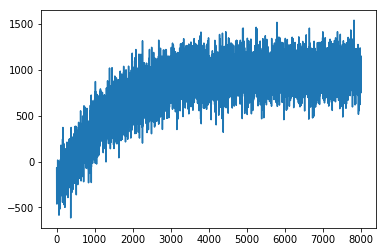

In [8]:
plt.plot(episodes,rewards_per_episode)

# The above graph shows that the rewards increased and stabilised after 4000 epochs as given by the epsilon function at the end of file

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [9]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

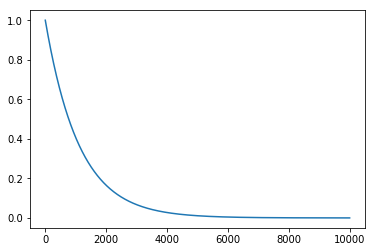

In [10]:
plt.plot(time, epsilon)
plt.show()

In [11]:
epsilon2=[]
for i in range(0,10000):
    if i==0:
        epsilon2.append(1)
    else:
        epsilon2.append(0.9991 * epsilon2[i-1])

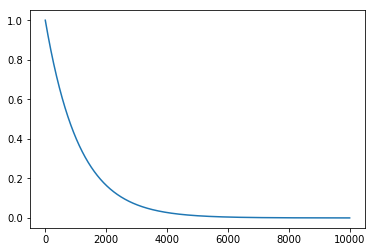

In [12]:
plt.plot(time, epsilon2)
plt.show()

# The above epsilon graph shows epsilon decaying and stabilizing after 4000 epochs as required by the previous epsilon decay graph. This epsilon decay rate has been used to train the model